<center>
    <h1>
        Analyzing Mortality Rates From Nutritional and Metabolic Diseases by U.S. County vs. Determinants of Food Access 
    </h1>        
    <h2>
        Group 6: Adam Cross, Mark Lee, Shreya Musini, Ellie Wang
    </h2>
</center>

## Introduction

In our project, we decided to study the mortality rates due to nutritional and metabolic diseases and explore some factors of food access that could contribute to these rates. This topic is essential to study because it examines the complex relationship between food accessibility and public health outcomes, more specifically nutritional and metabolic diseases like diabetes, cardiovascular disease, and hypertension, which are some of the leading causes of deaths in the United States. We are particularly interested in this topic because the prevalence of these diseases are closely related to dietary habits, which are significantly influenced by the availability and affordability of healthy food options.

Food deserts are defined as areas with limited access to affordable and nutritious food and disproportionately affect low-income, rural, and minority communities, according to the Food Empowerment Project (https://foodispower.org/access-health/food-deserts/). Within these areas,
residents of these communities typically struggle with an overabundance of fast-food outlets and convenience stores, both of which specialize mostly in processed, calorie-dense, and nutrient-poor food options. There are also a lack of options that are culturally appropriate for residents or do not consider dietary restrictions like lactose intolerance, gluten allergies, etc. The environmental factors combined with unhealthy eating patterns might further increase the risk of chronic diseases associated with poor nutrition.

Analyzing mortality rates from nutritional and metabolic diseases alongside food accessability factors gives us valuable insight on the health disparities and the social determinants that could possibly contribute to them. This is significant for developing a multidisciplinary approach that includes public health, urban planning, and social policy to address food insecurity and inaccessibility.

## Prior Analysis on Similar Data

While we could not find other open-source analysis on our particular datasets that we used in this project, this topic of analyzing mortality rates due to nutritional and metabolic diseases and the relation with food access determinants has been studied in the past. 

For instance, a study from the Journal of the National Cancer Institute analyzed the association between food deserts, food swamps, and obesity-related cancer mortality across the US. They discovered that counties with higher food desert scores faced elevated risks of suffering from obesity-related cancer. The food desert score was calculated through the consideration of factors like distance to the closest supermarket, availability of healthy food, and income.

(**Source**: https://www.researchgate.net/publication/370525715_Association_of_Food_Deserts_and_Food_Swamps_With_Obesity-Related_Cancer_Mortality_in_the_US)

Another study from the American Cancer Society found a strong association between both income levels and access to healthy foods with life expectancy. Their research found that living in a food deserts is associated with a shorter life expectancy. While not particularly focusing on nutritional and metabolic diseases, this study portrays the negative health effects that food deserts and other food access indicators have on our health and wellbeing.

(**Source**: https://pressroom.cancer.org/releases?item=1237)

Our study in particular focuses on the mortality rate of all types of nutritional and metabolic diseases and aims to explore the effects of some determinants of food access that are found in our datasets.

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import ks_2samp
import us
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Cleaning

### Food Access Dataset

Below is our Food Access dataset, collected from the United States Department of Agriculture's Food Access Research Atlas of 2019 that provides information of food access indicators country-wide. The data is recorded per Census Tract for a county on food access through the dataset. The dataset is large, with 72,531 instances and 147 different features with counties having multiple entries. Because each entry is identifiable by the census tract and not by county, we performed some data cleaning to aggregate the data to make the resulting data frame have each row represent one county's data. This also helped merge our data with the Cause of Death dataset, which identifies each entry by county.

In [148]:
# Import food desert dataset
df_food = pd.read_excel('FoodAccessResearchAtlasData2019.xlsx', sheet_name = 'Food Access Research Atlas')
df_food.head()

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.000000,0,...,221.0,1622.0,217.0,14.0,0.0,14.0,45.0,44.0,6.0,102.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.341014,1,...,214.0,888.0,1217.0,5.0,0.0,5.0,55.0,75.0,89.0,156.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.000000,0,...,439.0,2576.0,647.0,17.0,5.0,11.0,117.0,87.0,99.0,172.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.000000,0,...,904.0,4086.0,193.0,18.0,4.0,11.0,74.0,85.0,21.0,98.0
4,1001020500,Alabama,Autauga County,1,10766,4082,0,181.0,1.681219,0,...,1126.0,8666.0,1437.0,296.0,9.0,48.0,310.0,355.0,230.0,339.0


In [149]:
df_food.columns = df_food.columns.str.strip()

To change the food access dataset to be 1 entry per county, we combined all the tracts of a county by summing up the features. As well, some variables within the dataset represented a percentage of the tract that was calculated by dividing the county's total population feature for that census tract. Because of this, we removed all the columns that were shares in our dataset to have meaningful aggregates.

In [150]:
# The dataset is split up by tract, so we aim to combine all tracts of a county. Some variables are already defined as "shares" or percentages
# so we can remove all columns with share in name since they were a tract percentage divided by the county total population.
df_food_new = df_food.loc[:, ~df_food.columns.str.contains("share", case=False)]
df_food_new.head()

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.000000,0,...,221.0,1622.0,217.0,14.0,0.0,14.0,45.0,44.0,6.0,102.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.341014,1,...,214.0,888.0,1217.0,5.0,0.0,5.0,55.0,75.0,89.0,156.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.000000,0,...,439.0,2576.0,647.0,17.0,5.0,11.0,117.0,87.0,99.0,172.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.000000,0,...,904.0,4086.0,193.0,18.0,4.0,11.0,74.0,85.0,21.0,98.0
4,1001020500,Alabama,Autauga County,1,10766,4082,0,181.0,1.681219,0,...,1126.0,8666.0,1437.0,296.0,9.0,48.0,310.0,355.0,230.0,339.0


The variables we wanted to aggregate per county was chosen below by including all numerical features and dropping identifiers such as 'CensusTract' and binary variables like 'GroupQuartersFlag' and 'HUNVFlag', which represents group quarters that had a share of >= 67 and vehicle access where >= 100 households did not have access to a vehicle and were 1/2 a mile from the supermarkets. Combined_variables shows the variables of focus to combine when doing our aggregation.

In [151]:
# We can define the variables of a tract that we do want to combine when grouping by county
combined_variables = df_food_new.select_dtypes(include=['number']).drop(columns=['CensusTract', 'GroupQuartersFlag', 'HUNVFlag'], errors='ignore').columns.to_list()

To make our new dataframe, we grouped the instances by State and County to account for the same county existing in multiple states and took the sum of all the values per each state and county, with the new name of total_{variable_name} for each variable_name in our defined combined_variables list of important columns to aggregate. 'MedianFamilyIncome' was the only column that we decided to take the average of outside of the combined_variables list.

In [152]:
# Here we group by State and County and take the sum for all variables except 'MedianFamilyIncome', where we took the average of the tracts
# of a given county.
df_food_new = df_food_new.groupby(['State', 'County']).agg(
    # total_population=('Pop2010', 'sum'),
    avg_median_family_income=('MedianFamilyIncome', 'mean'),
    **{f'total_{var}': (var, 'sum') for var in combined_variables}
).reset_index()

After making the dataframe with our new summed values, we created a list of the columns of interest from combined_variables to note down all the variables from the new dataframe, df_food_new, for all the new shares we will calculate from the totaled columns.

In [153]:
# Define variable list that we want to create new shares from using 'total_population'
total_combined_variables=[x for x in combined_variables if x != "MedianFamilyIncome"]
total_combined_variables=[f'total_{i}' for i in combined_variables]

Then iteratively, we looped over all the variables that were greated from the summed aggregation and made shares of those variables by dividing the totals by the total population that was summed up for each county. Each of these new share columns were named as {variable}_share, with variable being the columns created from summing up the values per county per state. 

In [154]:
for var in total_combined_variables:
    df_food_new[f"{var}_share"] = df_food_new[var] / df_food_new["total_Pop2010"]
df_food_new.head()

,State,County,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,total_LILATracts_1And10,total_LILATracts_halfAnd10,...,total_TractSeniors_share,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share
0,Alabama,Autauga County,69337.500000,7,54571,20221,455.0,12.853691,5,5,...,0.119954,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330
1,Alabama,Baldwin County,72665.741935,14,182265,73180,2307.0,41.062742,4,4,...,0.167712,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513
2,Alabama,Barbour County,44792.444444,2,27457,9820,3193.0,79.735470,4,5,...,0.142368,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634
3,Alabama,Bibb County,60645.500000,0,22915,7953,2224.0,26.251382,0,0,...,0.126816,0.758499,0.220249,0.000960,0.000567,0.002793,0.016932,0.017718,0.017892,0.037050
4,Alabama,Blount County,60437.666667,1,57322,21578,489.0,7.248861,0,0,...,0.147221,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297


Before we merged our dataframe with the cause of death dataframe, we created 'State_Abbr' from the 'State' values in our dataframe to effectively merge by both the state and county. 

In [155]:
# Add state abbreviations in preparation for a merge with our other dataset
df_food_new = df_food_new.assign(State_Abbr=df_food_new['State'].map(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None))
df_food_new = df_food_new.drop(columns=["State"])

Below, df_food_new is our processed, cleaned version of the food access dataset.

In [156]:
df_food_new.head()

,County,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,total_LILATracts_1And10,total_LILATracts_halfAnd10,total_LILATracts_1And20,...,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share,State_Abbr
0,Autauga County,69337.500000,7,54571,20221,455.0,12.853691,5,5,3,...,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330,AL
1,Baldwin County,72665.741935,14,182265,73180,2307.0,41.062742,4,4,3,...,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513,AL
2,Barbour County,44792.444444,2,27457,9820,3193.0,79.735470,4,5,1,...,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634,AL
3,Bibb County,60645.500000,0,22915,7953,2224.0,26.251382,0,0,0,...,0.758499,0.220249,0.000960,0.000567,0.002793,0.016932,0.017718,0.017892,0.037050,AL
4,Blount County,60437.666667,1,57322,21578,489.0,7.248861,0,0,0,...,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297,AL


### Death by County Dataset 

This dataset is the underlying cause of death dataset, collected from 2018-2023 from the Centers for Disease Control and Prevention (CDC) WONDER database. The dataset has an instance for each county, identified by the County column by county name, state abbreviation and their County Code. The dataset has the columns County for the county, the County Code that identifies each county, the number of deaths recorded due to a nutritional and metabolic diseases in the Deaths column, the Population of the county, and the Crude Rate per 100,000 which is the percentage of deaths per 100,000 of the population. 

In [157]:
# Import mortality dataset
df_death = pd.read_excel('Underlying Cause of Death, 2018-2023, Single Race.xlsx')
df_death.head()

,County,County Code,Deaths,Population,"Crude Rate per 100,000"
0,"Autauga County, AL",1001.0,35,55869,62.6
1,"Baldwin County, AL",1003.0,108,223234,48.4
2,"Barbour County, AL",1005.0,11,24686,Unreliable
3,"Blount County, AL",1009.0,18,57826,Unreliable
4,"Butler County, AL",1013.0,24,19448,123.4


For data cleaning for this dataset, we created separate columns for the State and County of each county entry for easier merging with the Food Access dataset. 

In [158]:
# Create separate County and State columns in preparation for the merge
df_death["County_State"]=df_death["County"]
df_death['State'] = df_death['County_State'].str.split(", ").str[1]
df_death['County'] = df_death['County_State'].str.split(", ").str[0]
df_death.head()

,County,County Code,Deaths,Population,"Crude Rate per 100,000",County_State,State
0,Autauga County,1001.0,35,55869,62.6,"Autauga County, AL",AL
1,Baldwin County,1003.0,108,223234,48.4,"Baldwin County, AL",AL
2,Barbour County,1005.0,11,24686,Unreliable,"Barbour County, AL",AL
3,Blount County,1009.0,18,57826,Unreliable,"Blount County, AL",AL
4,Butler County,1013.0,24,19448,123.4,"Butler County, AL",AL


As well, we investigated the missingness in our data, which resulted in one county entry with null values. Since it was only one county that had null values, we removed that one county before further data cleaning and merging.

In [159]:
# Remove counties that have missing data.
df_death = df_death.dropna()
df_death.head()

,County,County Code,Deaths,Population,"Crude Rate per 100,000",County_State,State
0,Autauga County,1001.0,35,55869,62.6,"Autauga County, AL",AL
1,Baldwin County,1003.0,108,223234,48.4,"Baldwin County, AL",AL
2,Barbour County,1005.0,11,24686,Unreliable,"Barbour County, AL",AL
3,Blount County,1009.0,18,57826,Unreliable,"Blount County, AL",AL
4,Butler County,1013.0,24,19448,123.4,"Butler County, AL",AL


We filtered the dataset to only include County_State, State, County, and Deaths to merge with our Food Access dataset because the mortality rate per 100,000 will be recaculated using the total population aggregated by county from the food access dataset to have one column representing the mortality rate per county.

In [160]:
# Query only relevant columns. We will recalculate the crude mortality rate per 100,000 using 'Deaths' from this dataset and the total 
# population from the other dataset once we perform the merge.
df_death=df_death.filter(items=["County_State", "State", "County", "Deaths"])
df_death.head()

,County_State,State,County,Deaths
0,"Autauga County, AL",AL,Autauga County,35
1,"Baldwin County, AL",AL,Baldwin County,108
2,"Barbour County, AL",AL,Barbour County,11
3,"Blount County, AL",AL,Blount County,18
4,"Butler County, AL",AL,Butler County,24


We looked at the data types for each column we selected, which is shown below. County_State, State, and County were all objects and Deaths was an integer value. We remade the data types for County, State, and County_State as categories for further analysis.

In [161]:
df_death.dtypes

County_State    object
State           object
County          object
Deaths           int64
dtype: object

In [162]:
# Convert relevant columns to correct data type
df_death['County_State'] = df_death['County_State'].astype('category')
df_death['State'] = df_death['State'].astype('category')
df_death['County'] = df_death['County'].astype('category')
df_death.head()

,County_State,State,County,Deaths
0,"Autauga County, AL",AL,Autauga County,35
1,"Baldwin County, AL",AL,Baldwin County,108
2,"Barbour County, AL",AL,Barbour County,11
3,"Blount County, AL",AL,Blount County,18
4,"Butler County, AL",AL,Butler County,24


### Merging Datasets

After cleaning both the datasets, we merged the two datasets on their State and County values through an inner merge to keep counties that show up in both datasets. 

In [163]:
# Perform inner merge on the state abbreviation and county name from each dataset
df_merged = df_death.merge(df_food_new, how = 'inner', left_on = ['State', 'County'], right_on = ['State_Abbr', 'County'])
df_merged = df_merged.drop(columns=["State_Abbr"])
df_merged.head()

,County_State,State,County,Deaths,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,...,total_TractSeniors_share,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share
0,"Autauga County, AL",AL,Autauga County,35,69337.500000,7,54571,20221,455.0,12.853691,...,0.119954,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330
1,"Baldwin County, AL",AL,Baldwin County,108,72665.741935,14,182265,73180,2307.0,41.062742,...,0.167712,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513
2,"Barbour County, AL",AL,Barbour County,11,44792.444444,2,27457,9820,3193.0,79.735470,...,0.142368,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634
3,"Blount County, AL",AL,Blount County,18,60437.666667,1,57322,21578,489.0,7.248861,...,0.147221,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297
4,"Butler County, AL",AL,Butler County,24,50170.666667,2,20947,8491,333.0,11.934450,...,0.166563,0.544183,0.434191,0.008450,0.000334,0.002864,0.009978,0.009118,0.024825,0.059579


After merging, we calculated the new mortality rate by dividing the Death column by the total population column and multiplying it by 100000 to get a percent value of deaths caused by nutritional and metabolic diseases that is based on the entire county.

In [164]:
# Calculate new mortality rate based off of deaths from deaths dataframe and population based off food desert dataframe
df_merged['mortality_rate'] = df_merged['Deaths'] / df_merged['total_Pop2010'] * 100000
df_merged.head()

,County_State,State,County,Deaths,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,...,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share,mortality_rate
0,"Autauga County, AL",AL,Autauga County,35,69337.500000,7,54571,20221,455.0,12.853691,...,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330,64.136629
1,"Baldwin County, AL",AL,Baldwin County,108,72665.741935,14,182265,73180,2307.0,41.062742,...,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513,59.254382
2,"Barbour County, AL",AL,Barbour County,11,44792.444444,2,27457,9820,3193.0,79.735470,...,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634,40.062643
3,"Blount County, AL",AL,Blount County,18,60437.666667,1,57322,21578,489.0,7.248861,...,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297,31.401556
4,"Butler County, AL",AL,Butler County,24,50170.666667,2,20947,8491,333.0,11.934450,...,0.544183,0.434191,0.008450,0.000334,0.002864,0.009978,0.009118,0.024825,0.059579,114.574879


And lastly, we set the index to be the County_State to make each row identifiable by the county.

In [165]:
# Set index as County_State
df_cleaned = df_merged.set_index('County_State').drop(columns=["State", "County"])
df_cleaned.head()

,Deaths,avg_median_family_income,total_Urban,total_Pop2010,total_OHU2010,total_NUMGQTRS,total_PCTGQTRS,total_LILATracts_1And10,total_LILATracts_halfAnd10,total_LILATracts_1And20,...,total_TractWhite_share,total_TractBlack_share,total_TractAsian_share,total_TractNHOPI_share,total_TractAIAN_share,total_TractOMultir_share,total_TractHispanic_share,total_TractHUNV_share,total_TractSNAP_share,mortality_rate
County_State,,,,,,,,,,,,,,,,,,,,,
"Autauga County, AL",35,69337.500000,7,54571,20221,455.0,12.853691,5,5,3,...,0.785307,0.176706,0.008686,0.000586,0.004251,0.024464,0.024005,0.021825,0.049330,64.136629
"Baldwin County, AL",108,72665.741935,14,182265,73180,2307.0,41.062742,4,4,3,...,0.856736,0.093847,0.007396,0.000488,0.006672,0.034861,0.043848,0.014841,0.032513,59.254382
"Barbour County, AL",11,44792.444444,2,27457,9820,3193.0,79.735470,4,5,1,...,0.480023,0.468915,0.003897,0.001056,0.004152,0.041957,0.050515,0.030921,0.091634,40.062643
"Blount County, AL",18,60437.666667,1,57322,21578,489.0,7.248861,0,0,0,...,0.925788,0.013276,0.002041,0.000663,0.005356,0.052877,0.080702,0.014933,0.034297,31.401556
"Butler County, AL",24,50170.666667,2,20947,8491,333.0,11.934450,3,3,1,...,0.544183,0.434191,0.008450,0.000334,0.002864,0.009978,0.009118,0.024825,0.059579,114.574879


## EDA

To differentiate between areas with adequate and inadequate access to food, we created a new binary variable, `food_access_indicator`. This variable categorizes areas based on the proportion of the population with access to food within specific distances. Specifically, the value is set to 1 for populations with low food access—defined as areas where at least 50% of the population has limited access to food, within 1/2 mile in urban areas and 10 miles in rural areas. Areas with "better" access to food are assigned a value of 0. This indicator helps to facilitate the analysis of mortality rates in regions based on food access availability.

In [166]:
# 'food_access_indicator': 1 for populations with low food access within 1/2 mile in urban areas and 10 miles in rural areas, else 0
df_cleaned["food_access_indicator"] = ((df_cleaned['total_LAPOP05_10_share']) >= 0.50).astype(int)

In our EDA, we are aiming to uncover insights on significance of variables and relationships between them. We start off on looking at `mortality_rate` itself. This histogram visualizes the distribution of mortality rates per 100,000 along with a kernel density estimate (KDE). The histogram displays the frequency of different mortality rate values, while the KDE provides a smoothed curve that highlights the overall distribution pattern. This visualization that we created helps in understanding the spread and central tendency of mortality rates across the dataset.

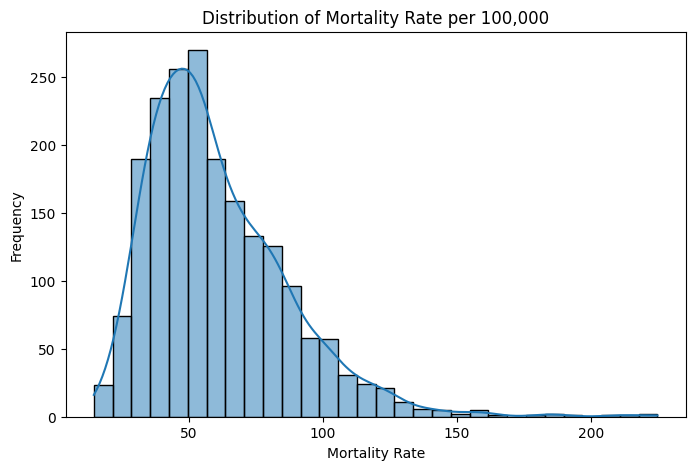

In [167]:
# Visualizes the distribution of mortality rates per 100,000 with a histogram and KDE.
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['mortality_rate'], bins=30, kde=True)
plt.title("Distribution of Mortality Rate per 100,000")
plt.xlabel("Mortality Rate")
plt.ylabel("Frequency")
plt.show()

To get a better idea of the spread of the distribution of key variables like `mortality_rate` and `avg_median_family_income`, we created two plots. 

1. **Mortality Rate Distribution (Left Plot)**: This plot shows the distribution of mortality rates across the dataset. The histogram, combined with a kernel density estimate (KDE), provides insight into the frequency and spread of mortality rates in the population. The distribution is right-skewed with a peak around 60-70 and a long tail extending beyond 150. This suggests that while most areas have lower mortality rates, a few outliers have significantly higher rates.



2. **Median Family Income Distribution (Right Plot)**: This plot illustrates the distribution of median family incomes. Similar to the mortality rate plot, the histogram and KDE help in understanding the variation in income levels across different counties. The distribution of family income is right-skewed, peaking around $60,000 to $70,000. A long tail extends toward higher income levels, indicating a few regions with much higher median family incomes.

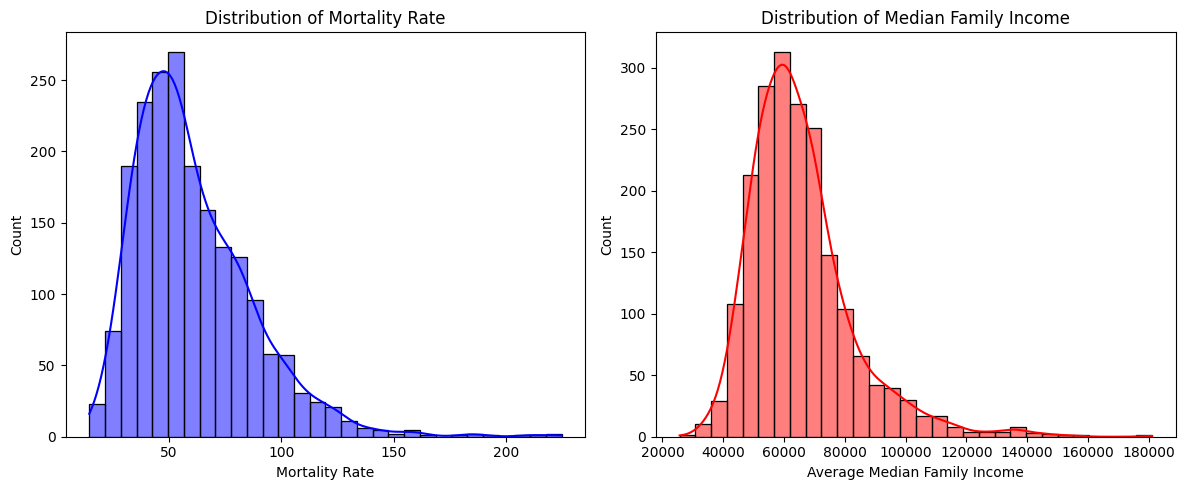

In [168]:
plt.figure(figsize=(12, 5))

# Mortality Rate Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['mortality_rate'], bins=30, kde=True, color="blue")
plt.xlabel("Mortality Rate")
plt.ylabel("Count")
plt.title("Distribution of Mortality Rate")

# Median Family Income Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['avg_median_family_income'], bins=30, kde=True, color="red")
plt.xlabel("Average Median Family Income")
plt.ylabel("Count")
plt.title("Distribution of Median Family Income")

plt.tight_layout()
plt.show()

Then, we created two scatter plots to explore potential relationships between the `mortality_rate` and other key variables:

**Mortality Rate vs. Average Tract Median Family Income**: This plot examines how changes in median family income may be associated with variations in mortality rates. It helps to assess whether areas with higher income have different mortality outcomes. The plot shows a general negative correlation, where higher median family incomes are associated with lower mortality rates. As family income increases, mortality rates tend to cluster toward lower values, suggesting a possible link between socioeconomic status and health outcomes.

**Mortality Rate vs. SNAP Recipients**: This plot looks at the relationship between the number of SNAP (Supplemental Nutrition Assistance Program) recipients in a tract and the mortality rate. This plot reveals a strong negative relationship between the number of SNAP recipients and mortality rates, with higher SNAP participation generally associated with higher mortality rates. As the number of SNAP recipients decreases, mortality rates tend to be lower, potentially indicating that areas with more SNAP recipients face higher mortality due to economic hardship or related factors.

Both plots suggest that income and socioeconomic factors may influence mortality rates, with wealthier areas generally experiencing lower mortality.

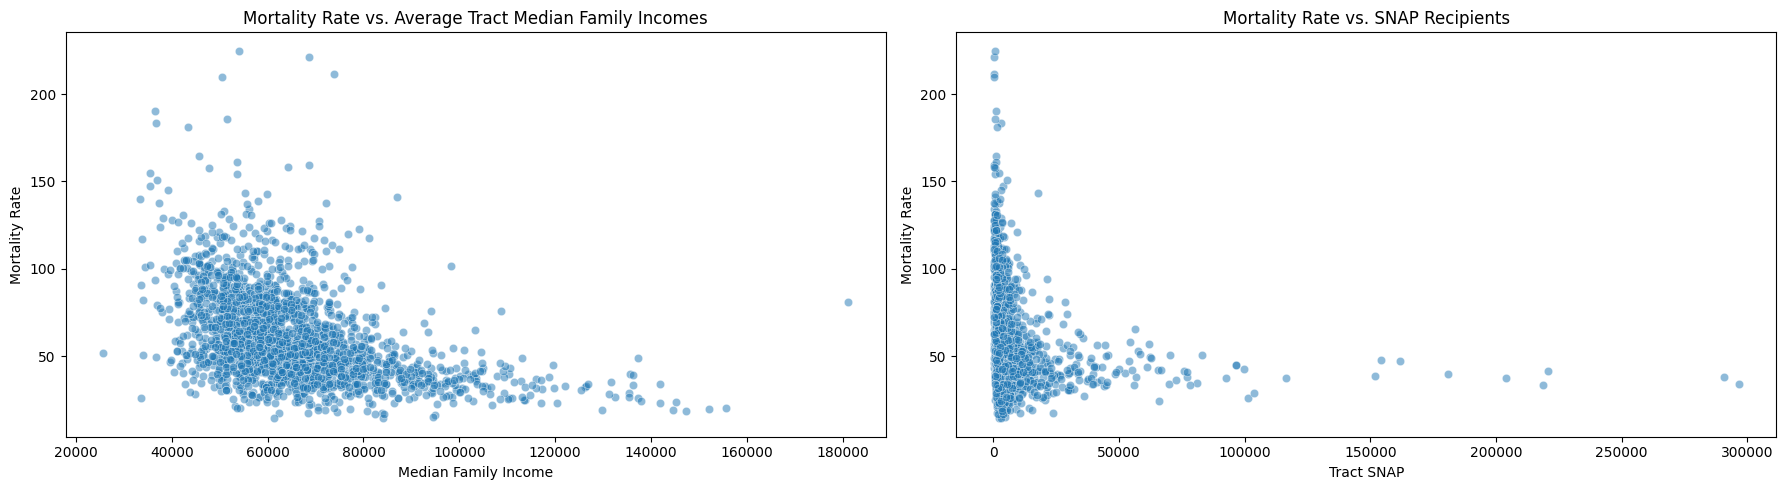

In [169]:
# Created scatter plots to visualize relationships between mortality rate and median family income, and mortality rate and SNAP recipients
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# mortality vs. median family income
sns.scatterplot(x=df_cleaned['avg_median_family_income'], y=df_cleaned['mortality_rate'], ax=axes[0], alpha=0.5)
axes[0].set_title("Mortality Rate vs. Average Tract Median Family Incomes")
axes[0].set_xlabel("Median Family Income")
axes[0].set_ylabel("Mortality Rate")

# mortality rate vs. SNAP recipients
sns.scatterplot(x=df_cleaned['total_TractSNAP'], y=df_cleaned['mortality_rate'], ax=axes[1], alpha=0.5)
axes[1].set_title("Mortality Rate vs. SNAP Recipients")
axes[1].set_xlabel("Tract SNAP")
axes[1].set_ylabel("Mortality Rate")

plt.tight_layout()
plt.show()


Next, we created a scatter plot to visualize the relationship between mortality rate and average median family income. The plot includes a regression line (in red) to help highlight the trend between these two variables. This visualization allows us to assess whether areas with higher median family income show different mortality rates. 
- There is a clear negative correlation, indicating that as average median family income increases, the mortality rate tends to decrease.
- Most data points are concentrated in the lower income ranges (between \$40,000 to \$80,000), and the mortality rate tends to cluster between 50 and 150 per 100,000 people.
- This suggests that higher family incomes are generally associated with better health outcomes and lower mortality rates.

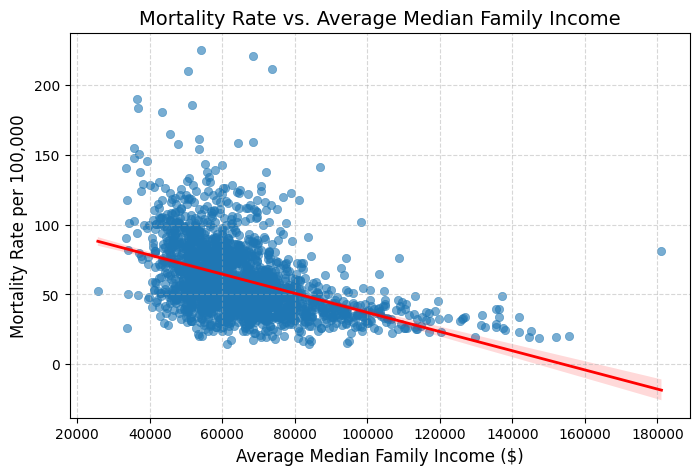

In [170]:
# Created scatter plot with a regression line to visualize the relationship between mortality rate and average median family income
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_cleaned['avg_median_family_income'], y=df_cleaned['mortality_rate'], alpha=0.6, edgecolor=None)
sns.regplot(x=df_cleaned['avg_median_family_income'], y=df_cleaned['mortality_rate'], scatter=False, color='red', line_kws={"linewidth": 2})

plt.title("Mortality Rate vs. Average Median Family Income", fontsize=14)
plt.xlabel("Average Median Family Income ($)", fontsize=12)
plt.ylabel("Mortality Rate per 100,000", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

We then created a heatmap that aims to visualize the correlation matrix of a selected set of variables in the dataset. Specifically, it calculates the pairwise correlation coefficients between the mortality rate, average median family income, total SNAP recipients, and share of households with low access to food (total_lahunvhalf_share).

The correlation heatmap reveals key relationships between variables:

- **Mortality rate** is negatively correlated with **median family income** (-0.44), indicating that areas with higher income tend to have lower mortality rates.
- **Food inaccessibility (total_lahunvhalf_share)** has a moderate positive correlation with **mortality rate** (0.32), suggesting that limited food access may contribute to higher mortality rates.
- **SNAP participation (total_TractSNAP)** has a weak negative correlation with **mortality rate** (-0.18), implying that areas with more SNAP recipients may have slightly lower mortality rates, though the relationship is weak.
- **Income** and **food inaccessibility** are inversely correlated (-0.52), meaning lower-income areas are more likely to experience food inaccessibility.

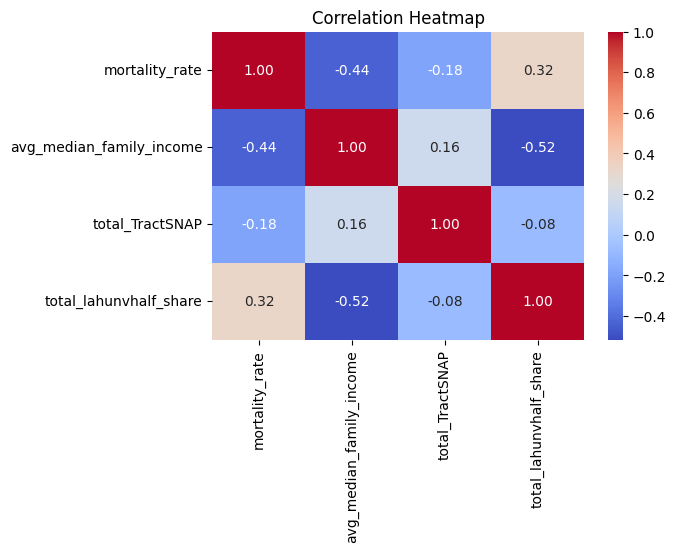

In [171]:
# Heatmap to visualize the correlation matrix of certain variables
corr_vars = ['mortality_rate', 'avg_median_family_income', 'total_TractSNAP', 'total_lahunvhalf_share']
corr_matrix = df_cleaned[corr_vars].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Finally we generated a boxplot to visualize and compare the mortality rates in areas with high access to food versus areas with low access. Key observations include: 
- Low-access areas have a higher median mortality rate than high-access areas.
- The interquartile range (IQR) is slightly wider for low-access areas, indicating more variability in mortality rates.
- Both groups have outliers with extremely high mortality rates, though they appear more frequent in low-access areas.

/var/folders/7g/xw6rhgc51gzc64y3603lftr40000gn/T/ipykernel_18100/797872992.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cleaned['food_access_indicator'], y=df_cleaned['mortality_rate'], palette=["red", "blue"])


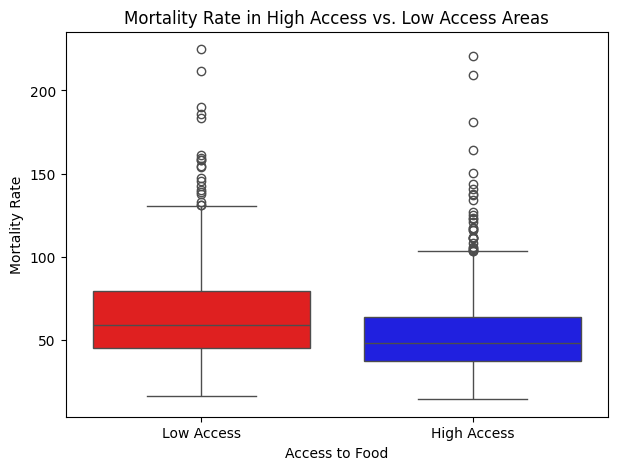

In [172]:
# Boxplot of Mortality Rate in High Access vs. Low Access counties 

plt.figure(figsize=(7, 5))
sns.boxplot(x=df_cleaned['food_access_indicator'], y=df_cleaned['mortality_rate'], palette=["red", "blue"])
plt.xticks(ticks=[0, 1], labels=["Low Access", "High Access"])  
plt.xlabel("Access to Food")
plt.ylabel("Mortality Rate")
plt.title("Mortality Rate in High Access vs. Low Access Areas")
plt.show()

Then, we grouped the data by the 'food_access_indicator' variable (which indicates high or low food access) and computes summary statistics for the mortality rate within each group to understand the distribution of mortality rates in both high-access and low-access areas and check for any significant differences between them. 

In [173]:
# Grouping by 'food_access_indicator' and summarizing the mortality rate statistics
print(df_cleaned.groupby("food_access_indicator")["mortality_rate"].describe())

                        count       mean        std        min        25%  \
food_access_indicator                                                       
0                      1299.0  64.416608  26.382220  16.559755  45.032854   
1                       682.0  53.651939  24.817995  14.518327  37.351517   

                             50%        75%         max  
food_access_indicator                                    
0                      59.253407  79.442278  224.763022  
1                      48.200595  63.786636  220.896841  


The summary statistics show that low-access areas have a higher mean mortality rate (64.42 vs. 53.65 per 100,000) and greater variability than high-access areas. The median mortality rate is also higher in low-access areas (59.25 vs. 48.20). While both groups exhibit wide mortality rate ranges, the slightly lower standard deviation in high-access areas suggests less variability. These differences indicate a potential link between food access and mortality rates, and we explore this idea later. 

### County Mortality Rate and Supermarket Distances

We next wanted to explore the relationship between a county's mortality rate and its population's distance from a supermarket. The heatmap below shows the correlation between a county's mortality rate and the count of people who live beyond a half mile (total_lapophalf), 1 mile (total_lapop1), 10 miles (total_lapop10), and 20 miles (total_lapop20) from a supermarket. 

We can see that a distance beyond a half to whole mile seems to have the greatest correlation with a county's mortality rate. This result informs our further exploration of shorter minimum distances from supermarkets.

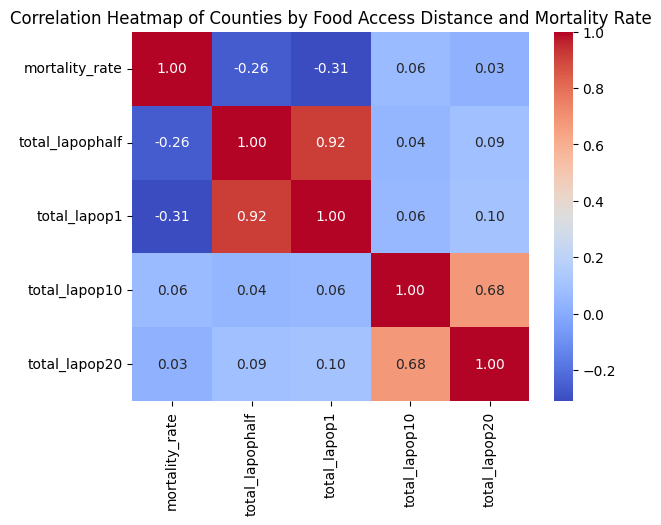

In [174]:
# Heatmap of low access populations by distance from supermarket
relevant_columns = ['mortality_rate', 'total_lapophalf',
                     'total_lapop1', 'total_lapop10', 'total_lapop20']
sns.heatmap(df_cleaned[relevant_columns].corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title("Correlation Heatmap of Counties by Food Access Distance and Mortality Rate")
plt.show()

After identifing that a population with a shorter minimum distance from a supermarket has having a greater correlation with a county's mortality rate, we wanted to explore the correlation between subgroups within the half mile distance category. 

The heatmap below shows the correlation between mortaility rate and the percent of its population beyond a half mile from a supermarkt broken down by race. The race categories are as follows:
 * White population beyond a half mile (total_lawhitehalf_share)
 * Black or African American population beyond a half mile (total_lablackhalf_share)
 * Asian population beyond a half mile (total_laasianhalf_share)
 * Native Hawaiian or Pacific Islander population beyond a half mile (total_lanhopihalf_share),
 * American Indian or Alaskan Native population beyond a half mile (total_laaianhalf_share), 
 * Other or mixed race population beyond a half mile (total_laomultirhalf_share)
 * Hispanic population beyond a half mile (total_lahisphalf_share).

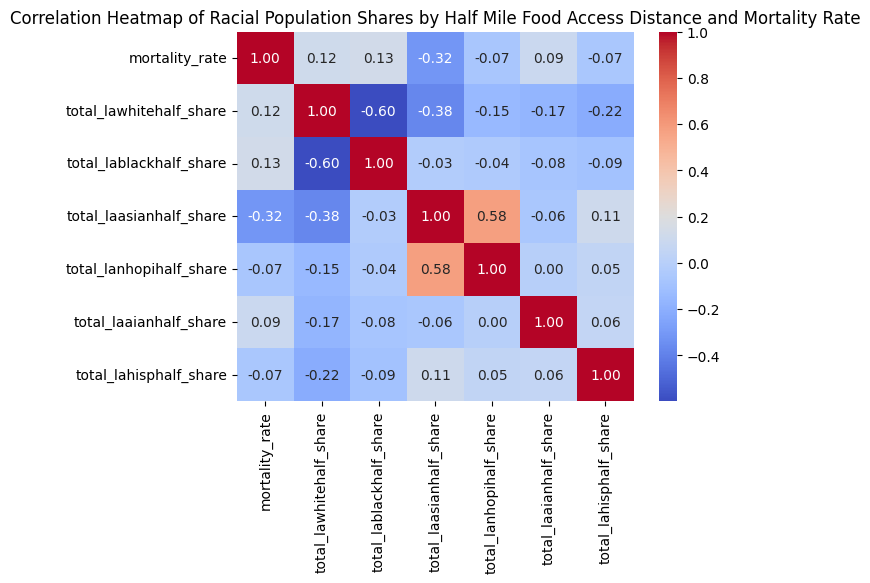

In [175]:
# Heat map of county population half mile from supermarket by race
relevant_columns = ['mortality_rate', 'total_lawhitehalf_share', 'total_lablackhalf_share',
                    'total_laasianhalf_share', 'total_lanhopihalf_share', 'total_laaianhalf_share',
                    'total_lahisphalf_share']
sns.heatmap(df_cleaned[relevant_columns].corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title("Correlation Heatmap of Racial Population Shares by Half Mile Food Access Distance and Mortality Rate")
plt.show()

### Correlation Significance

After examining the correlation between a county population's distance from a supermarket and mortality rate we wanted to ensure that these measured relationships were statistically significant. The P-value below shows the statistical significance of the percenatage of people in a county who live beyond a half mile from a supermarket on mortality.

In [176]:
# Calulate P-value for correlation between 
# mortality rate and county population half mile from supermarket


# Drop NaN values from examined columns.
df_cleaned_nandroped = df_cleaned.dropna(subset=['mortality_rate', 'total_lapophalf_share'])

# Compute Pearson correlation coefficient and p-value
corr, p_value = pearsonr(df_cleaned_nandroped['mortality_rate'], df_cleaned_nandroped['total_lapophalf_share'])

print(f"Pearson Correlation: {corr}")
print(f"P-value: {p_value}")

# Check significance
alpha = 0.05  # Common significance level (5%)
if p_value < alpha:
    print("The correlation is statistically significant.")
else:
    print("The correlation is NOT statistically significant.")


Pearson Correlation: 0.2585942453002774
P-value: 1.2454974446155588e-31
The correlation is statistically significant.


The correlation between the average medain family income across cencus tracts in a county and mortality rate is also obersved below. The moderate correclation between the two can be seen as statistically significant as well. 

In [177]:
# Calulate P-value for correlation between 
# mortality rate and average Census tract median family income in a county.

# Drop NaN values from examined columns.
df_cleaned_nandroped = df_cleaned.dropna(subset=['mortality_rate', 'avg_median_family_income'])

# Compute Pearson correlation coefficient and p-value
corr, p_value = pearsonr(df_cleaned_nandroped['mortality_rate'], df_cleaned_nandroped['avg_median_family_income'])

print(f"Pearson Correlation: {corr}")
print(f"P-value: {p_value}")

# Check significance
alpha = 0.05  # Common significance level (5%)
if p_value < alpha:
    print("The correlation is statistically significant.")
else:
    print("The correlation is NOT statistically significant.")

Pearson Correlation: -0.4435579811025938
P-value: 3.2113295857416646e-96
The correlation is statistically significant.


The observed significance of both these variables on mortality rate reinforces their further analysis in this report.

## Hypothesis Testing

To begin our hypothesis testing, we thought of using a t-test to determine whether there is a significant difference between the means of two groups, `mortality_rate` and `food_access_indicator`. Before proceeding with a t-test, we had to check the three key assumptions of a t-test: 
1. **Normality** – the data in each group should be approximately normally distributed
2. **Equal Variance** – the variability (spread) of the two groups should be similar
3. **Independence** – the observations in one group should not influence observations in the other group

Therefore, we plotted histograms to visualize the distribution mortality rates in low and high food access areas. 

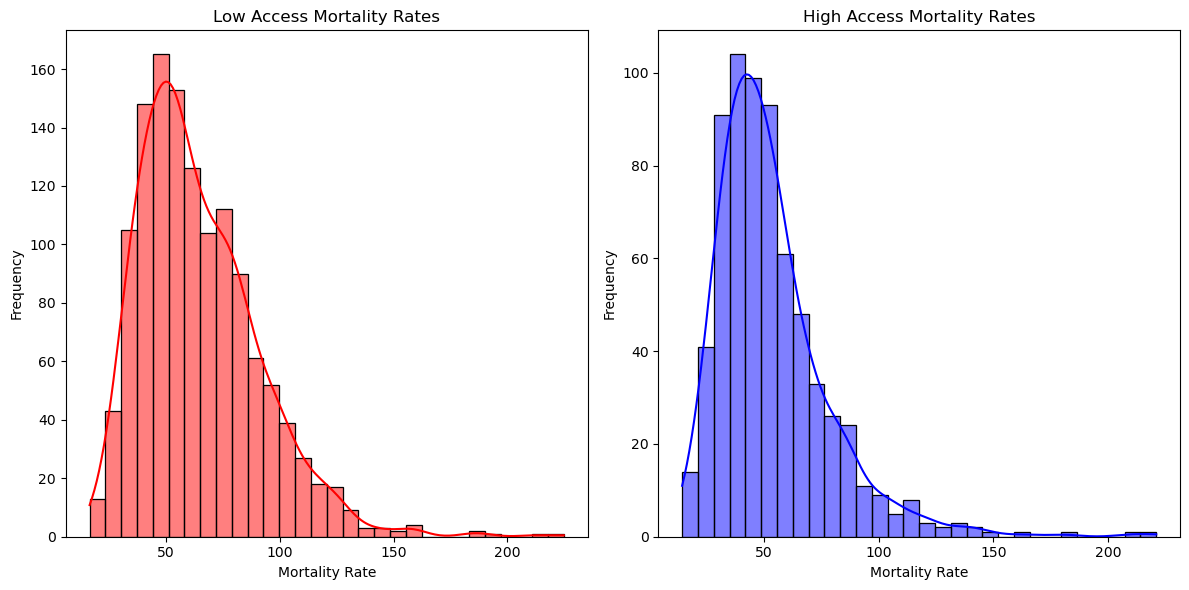

In [75]:
# Histograms comparing mortality rates in low and high food access areas
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_cleaned[df_cleaned['food_access_indicator'] == 0]['mortality_rate'], bins=30, kde=True, color='red')
plt.title("Low Access Mortality Rates")
plt.xlabel("Mortality Rate")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(df_cleaned[df_cleaned['food_access_indicator'] == 1]['mortality_rate'], bins=30, kde=True, color='blue')
plt.title("High Access Mortality Rates")
plt.xlabel("Mortality Rate")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

From these histograms, we observe that both distributions appear to be right-skewed, indicating potential deviation from normality. This suggests the need for further assessment of normality before conducting a parametric test like the t-test. To further check for normality, we then proceeded to create QQ plots. We know that if the data follows a normal distribution, the points should align closely with the red diagonal line. 

### QQ plots of low vs high food access areas

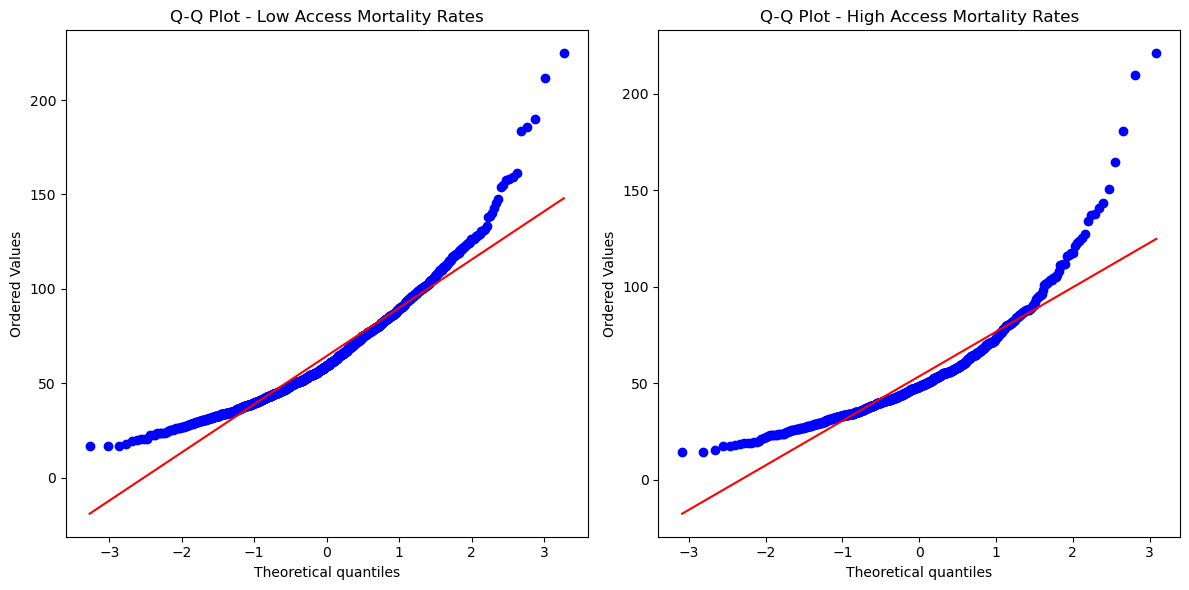

In [78]:
# Q-Q plots to assess the normality of mortality rates in low and high food access areas
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(df_cleaned[df_cleaned['food_access_indicator'] == 0]['mortality_rate'], dist="norm", plot=plt)
plt.title("Q-Q Plot - Low Access Mortality Rates")

plt.subplot(1, 2, 2)
stats.probplot(df_cleaned[df_cleaned['food_access_indicator'] == 1]['mortality_rate'], dist="norm", plot=plt)
plt.title("Q-Q Plot - High Access Mortality Rates")

plt.tight_layout()
plt.show()

In our plots, we observe significant deviations from normality, particularly at the tails, which suggests the presence of skewness and outliers. Given the results from both the histograms and Q-Q plots, it is evident that the normality assumption for a t-test is likely violated. Therefore, we proceeded with an alternative path. 

### Kolmogorov-Smirnov (KS) test

We decided to use the Kolmogorov-Smirnov (KS) test. This test is a non-parametric statistical test that compares the cumulative distribution functions (CDFs) of two independent samples. Unlike the t-test, it does not assume normality or equal variance, making it more robust for skewed or non-normally distributed data, which was what we had. 

In [82]:
# KS test to compare the distribution of mortality rates between high and low food access groups
high_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == 1]['mortality_rate']
low_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == 0]['mortality_rate']

statistic, p_value = ks_2samp(high_food_access_group, low_food_access_group)

print(f"KS Test statistic: {statistic}, p-value: {p_value}")

KS Test statistic: 0.21065493646138808, p-value: 7.224501751217153e-18


With our KS test statistic of 0.211 and a p-value of basically 0, since this p-value is much smaller than 0.05, we reject the null hypothesis, meaning there is a statistically significant difference in the distributions of mortality rates between low and high food access areas. We can assume that mortality rates are distributed differently in counties with low vs. high food access, supporting the idea that food access may be associated with mortality outcomes. 

To further investigate the difference in mortality rate distributions between areas with high and low food access, we plot their Cumulative Distribution Functions (CDFs).

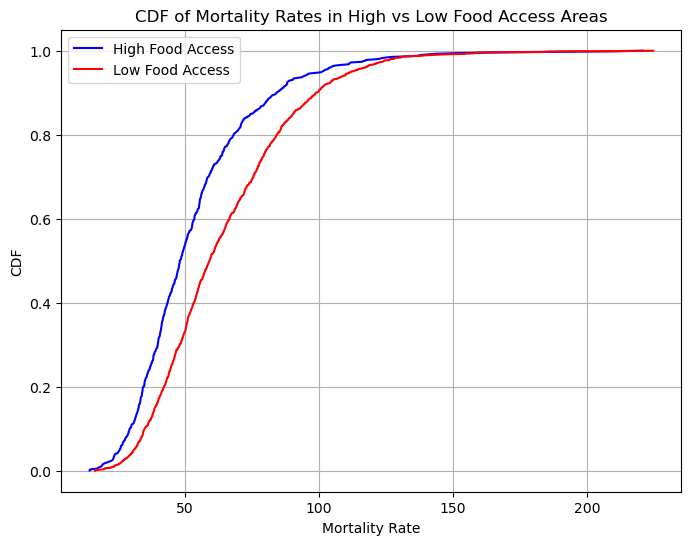

In [84]:
# Visualizing CDF of mortality rates for high and low food access areas
high_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == 1]['mortality_rate']
low_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == 0]['mortality_rate']

high_food_access_sorted = np.sort(high_food_access_group)
low_food_access_sorted = np.sort(low_food_access_group)

high_food_access_cdf = np.arange(1, len(high_food_access_sorted)+1) / len(high_food_access_sorted)
low_food_access_cdf = np.arange(1, len(low_food_access_sorted)+1) / len(low_food_access_sorted)

plt.figure(figsize=(8, 6))
plt.plot(high_food_access_sorted, high_food_access_cdf, label='High Food Access', color='blue')
plt.plot(low_food_access_sorted, low_food_access_cdf, label='Low Food Access', color='red')
plt.xlabel('Mortality Rate')
plt.ylabel('CDF')
plt.title('CDF of Mortality Rates in High vs Low Food Access Areas')
plt.legend()
plt.grid(True)
plt.show()

Comparing the two lines, the blue line (high food access) lies above the red line (low food access), suggesting that mortality rates tend to be lower in areas with high food access. The red line shifts to the right, indicating that mortality rates tend to be higher in these areas.

The plot suggests that areas with low food access experience higher mortality rates, as their CDF accumulates more slowly than areas with high food access. We can further say that mortality rates are significantly different between high and low food access areas, with higher mortality rates in low food access regions.

### Permutation Test

Then, we decided to perform a permutation test as it is also a non-parametric method that does not rely on assumptions about normality, which were violated in our dataset. The permutation test directly evaluates the difference in mortality rates by randomly shuffling group labels and comparing observed differences to a null distribution, providing a more robust assessment of statistical significance.

We first began to prepare the data by treating a single DataFrame that combines mortality rates from both high and low food access areas, along with labels indicating which group each data point belongs to.

In [89]:
# Combining mortality rate data for high and low food access groups into a single DataFrame with labels for each group
high_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == True]['mortality_rate']
low_food_access_group = df_cleaned[df_cleaned['food_access_indicator'] == False]['mortality_rate']

combined_mortality_rate = np.concatenate([high_food_access_group.values, low_food_access_group.values])
labels = np.concatenate([np.ones(len(high_food_access_group)), np.zeros(len(low_food_access_group))])
combined_df = pd.DataFrame({'mortality_rate': combined_mortality_rate, 'is_high_food_access': labels})
combined_df.head()

,mortality_rate,is_high_food_access
0,64.136629,1.0
1,30.361299,1.0
2,38.583082,1.0
3,53.624437,1.0
4,46.927252,1.0


Our permutation test works to compare the mean mortality rates between two groups: high food access and low food access. It first calculates the observed difference in the means of the mortality rates between these two groups. Then, it randomly permutes the combined data of both groups multiple times (10,000 permutations in this case) and recalculates the mean difference for each permutation. The test then calculates the p-value by determining the proportion of permutations where the absolute difference in means is greater than or equal to the observed difference. A p-value of 0.0 indicates that the observed difference in means is highly unlikely to have occurred by chance.

**Conclusion**: The observed difference in mortality rates between high and low food access groups is statistically significant, with a p-value of 0.0, suggesting that the observed difference is highly unlikely to have occurred randomly. This implies that food access may have a significant impact on mortality rates.

In [91]:
# Performing a permutation test to compare the means of mortality rates between high and low food access groups

high_food_access_group = combined_df[combined_df['is_high_food_access'] == 1]['mortality_rate']
low_food_access_group = combined_df[combined_df['is_high_food_access'] == 0]['mortality_rate']

observed_diff = high_food_access_group.mean() - low_food_access_group.mean()
combined_data = np.concatenate([high_food_access_group, low_food_access_group])
n_permutations = 10000
permuted_diffs = []

for _ in range(n_permutations):
    permuted_data = np.random.permutation(combined_data) 
    perm_high_food_access = permuted_data[:len(high_food_access_group)]  
    perm_low_food_access = permuted_data[len(high_food_access_group):]
    perm_diff = perm_high_food_access.mean() - perm_low_food_access.mean()
    permuted_diffs.append(perm_diff)
permuted_diffs = np.array(permuted_diffs)

# Calculating the p-value to test if the observed difference in means is statistically significant
p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))

print(f"Observed difference in means: {observed_diff}")
print(f"Permutation test p-value: {p_value}")

Observed difference in means: -10.764668907420216
Permutation test p-value: 0.0


## Regression Modeling

We want to take a deeper look into the key risk factors that contribute to the highest county-wide mortality rates in our data. To accomplish this, we can contruct a regression model with an optimal set of variables to predict the mortality rate. This model can potentially give us insight on what populations suffer the most from food deserts and how to focus public health efforts to reduce food insecurity among US counties.

### Interested Variables

There are over 180 variables associated with each county in our cleaned, merged dataset, so we need to cut down and focus just on the variables we are most interested in. We identified the following 10 variables to include in our model, based on their description and correlation matrix defined above in the exploratory data analysis section. Intuitively, these variables can shed valuable insight on the nutritional and metabolic mortality rate in these US counties. 

The variables are described as follows:

1. 'avg_median_family_income' \[continuous quantitative]: The arithmetic average of the median income of each tract within a county.
2. 'total_lapophalf_share' \[continuous quantitative]: Share of county population that are beyond 1/2 mile from supermarket
3. 'total_lalowihalf_share' \[continuous quantitative]: Share of county population that are low income individuals beyond 1/2 mile from supermarket
4. 'total_lawhitehalf_share' \[continuous quantitative]: Share of county population that are white beyond 1/2 mile from supermarket
5. 'total_lablackhalf_share' \[continuous quantitative]: Share of county population that are Black or African American beyond 1/2 mile from supermarket
6. 'total_laasianhalf_share' \[continuous quantitative]: Share of county population that are Asian beyond 1/2 mile from supermarket
7. 'total_laaianhalf_share' \[continuous quantitative]: Share of county population that are American Indian or Alaska Native beyond 1/2 mile from supermarket
8. 'total_lahisphalf_share' \[continuous quantitative]: Share of county population that are of Hispanic or Latino ethnicity beyond 1/2 mile from supermarket
9. 'total_lahunvhalf_share' \[continuous quantitative]: Share of county housing units that are without vehicle and beyond 1/2 mile from supermarket
10. 'total_Pop2010' \[discrete quantitative]: Population count from 2010 census for each county

The response variable 'mortality_rate' is a continuous quantitative data type, which is the crude mortality rate due to nutritional and metabolic diseases per 100,000 in a given US county.

In [178]:
interested_variables = [
    'avg_median_family_income', 'total_lapophalf_share', 'total_lalowihalf_share', 'total_lawhitehalf_share', 'total_lablackhalf_share',
    'total_laasianhalf_share', 'total_laaianhalf_share', 'total_lahisphalf_share', 'total_lahunvhalf_share', 'total_Pop2010', 'mortality_rate'
]

It is important for our features to have limited (and ideally none) missing values. As shown below, each of our 10 interested variables have no missing values (except for 'avg_median_family_income' with a singular missing value). This is a result of the usage of groupby, which summed together relevant numerical data for each tract of a county to give a county total. Values from tracts that were missing were simply not included in this total.

Consequently, we do not need to apply any imputation techniques to handle missing values.

In [179]:
for feature in interested_variables:
    missing_count=df_cleaned[feature].isna().sum()
    print(f'Missing values for feature {feature}:', missing_count, f'({np.round(missing_count/df_cleaned.shape[0], decimals=2)}% missing)')

Missing values for feature avg_median_family_income: 1 (0.0% missing)
Missing values for feature total_lapophalf_share: 0 (0.0% missing)
Missing values for feature total_lalowihalf_share: 0 (0.0% missing)
Missing values for feature total_lawhitehalf_share: 0 (0.0% missing)
Missing values for feature total_lablackhalf_share: 0 (0.0% missing)
Missing values for feature total_laasianhalf_share: 0 (0.0% missing)
Missing values for feature total_laaianhalf_share: 0 (0.0% missing)
Missing values for feature total_lahisphalf_share: 0 (0.0% missing)
Missing values for feature total_lahunvhalf_share: 0 (0.0% missing)
Missing values for feature total_Pop2010: 0 (0.0% missing)
Missing values for feature mortality_rate: 0 (0.0% missing)


Here, we can just drop the one county that had missing data for its family income.

In [181]:
# Drop 1 missing value and create DataFrame with only the features we are interested in using for our regression model
df_reg_var = df_cleaned.loc[:, interested_variables].dropna()
df_reg_var.head()

,avg_median_family_income,total_lapophalf_share,total_lalowihalf_share,total_lawhitehalf_share,total_lablackhalf_share,total_laasianhalf_share,total_laaianhalf_share,total_lahisphalf_share,total_lahunvhalf_share,total_Pop2010,mortality_rate
County_State,,,,,,,,,,,
"Autauga County, AL",69337.500000,0.907045,0.284362,0.709159,0.164699,0.006841,0.003958,0.021368,0.019133,54571,64.136629
"Baldwin County, AL",72665.741935,0.908675,0.263985,0.782021,0.082056,0.006344,0.006216,0.040153,0.011952,182265,59.254382
"Barbour County, AL",44792.444444,0.865444,0.433441,0.430836,0.388772,0.002695,0.003968,0.046319,0.027043,27457,40.062643
"Blount County, AL",60437.666667,0.958304,0.345547,0.889136,0.012482,0.001851,0.005162,0.074355,0.014337,57322,31.401556
"Butler County, AL",50170.666667,0.862436,0.412879,0.484572,0.358852,0.006969,0.002787,0.008545,0.025840,20947,114.574879


### Transforming Data 

To better capture the relationship between mortality rate (dependent variable) and our key independent variables, we applied a log transformation to our data. This transformation helps linearize relationships, making them more suitable for OLS regression. Additionally, it mitigates the skewness often observed in variables such as income and population.

The QQ-plots below illustrate how the log transformation affects the distribution of these variables. Notably, many variables become more normally distributed, which improves model performance and interpretation.

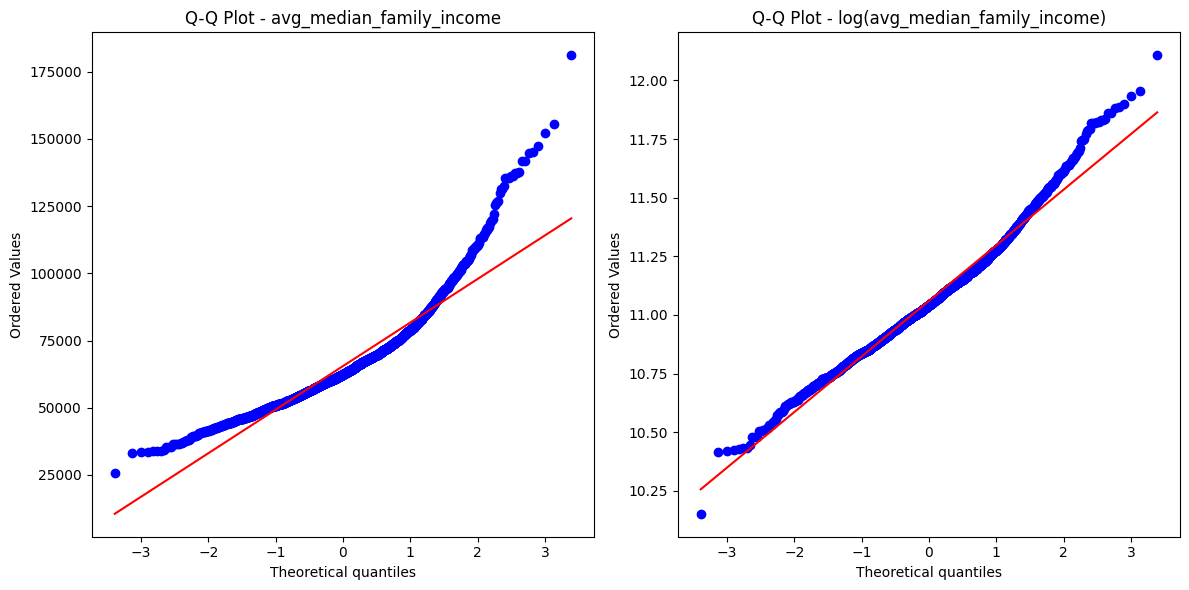

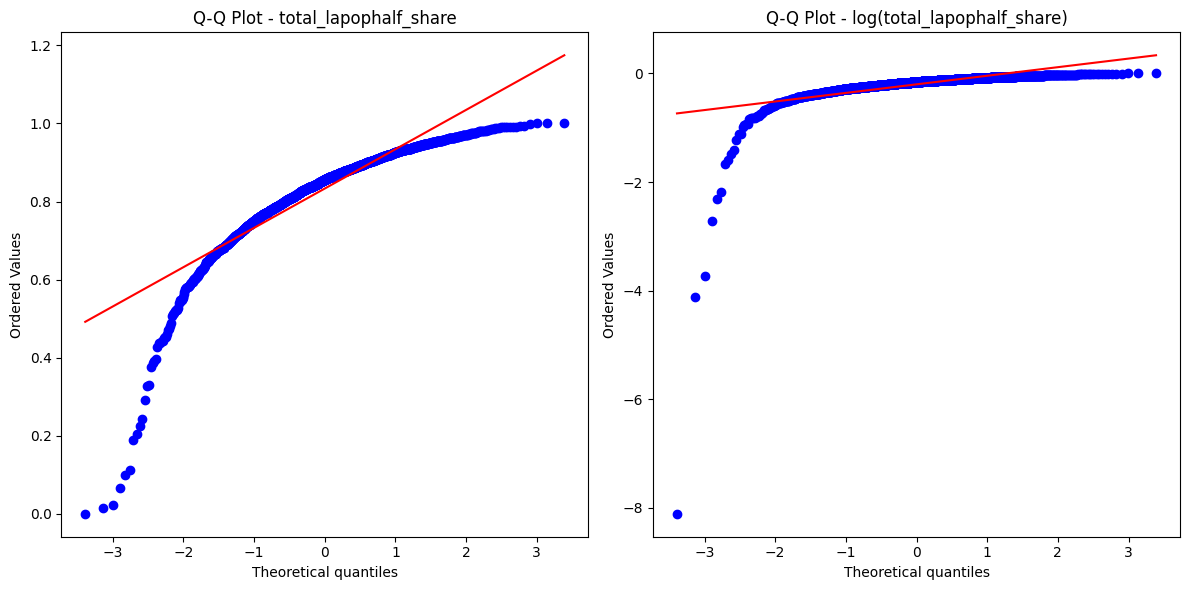

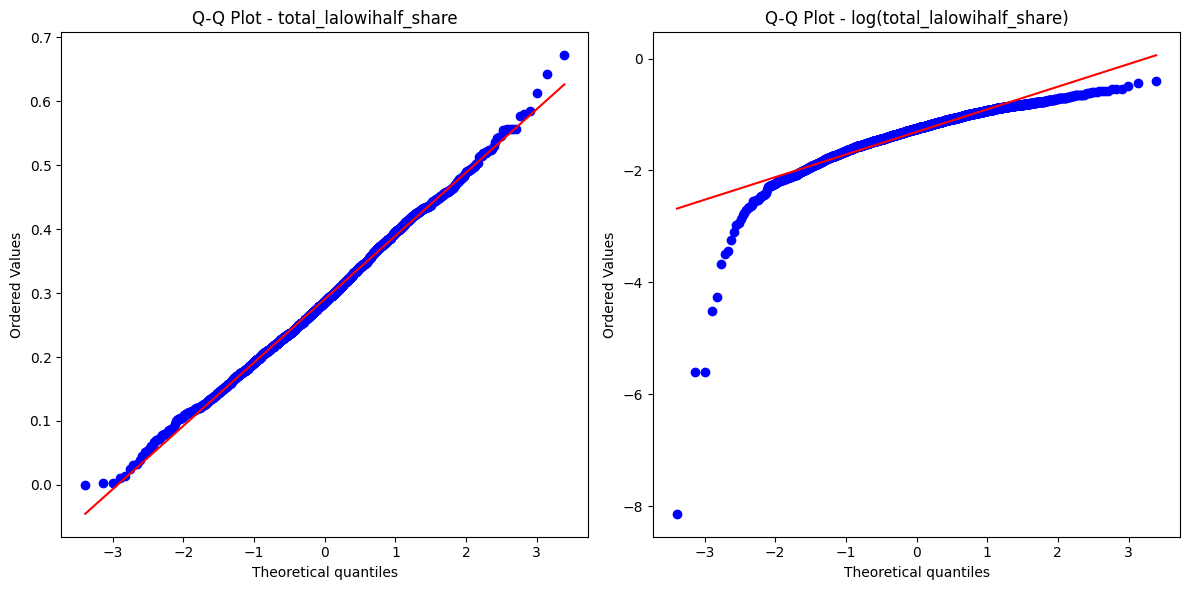

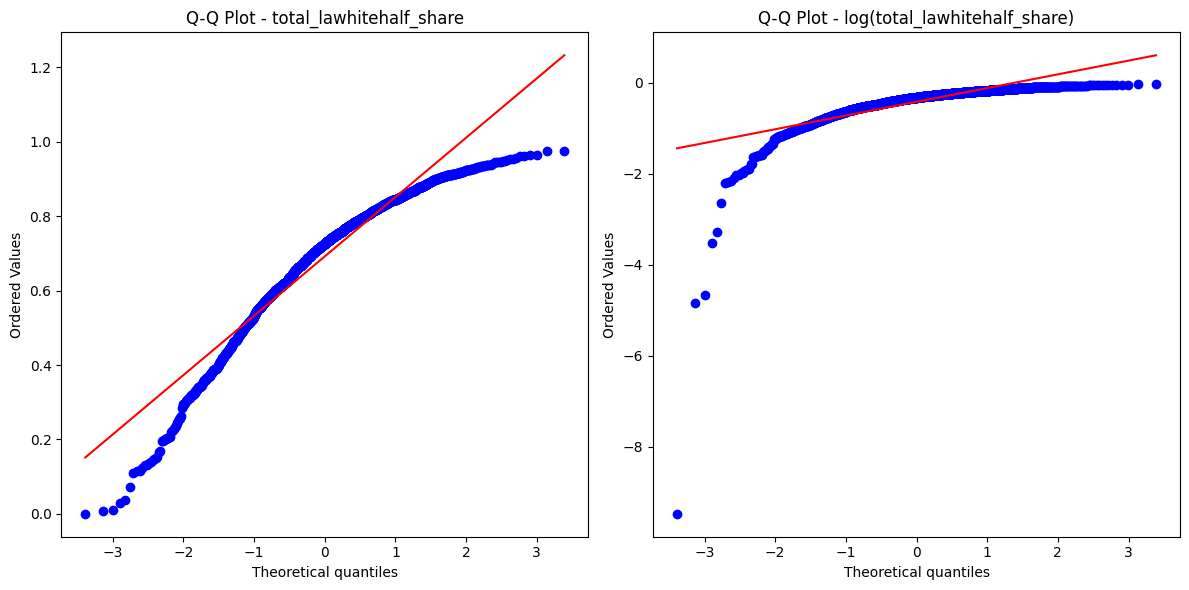

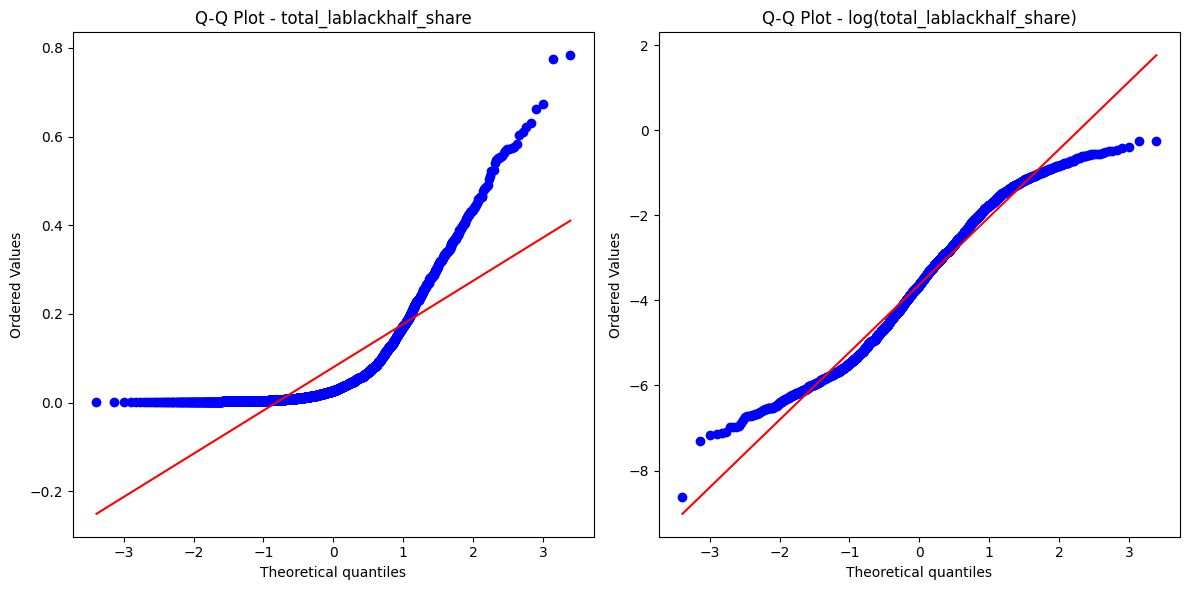

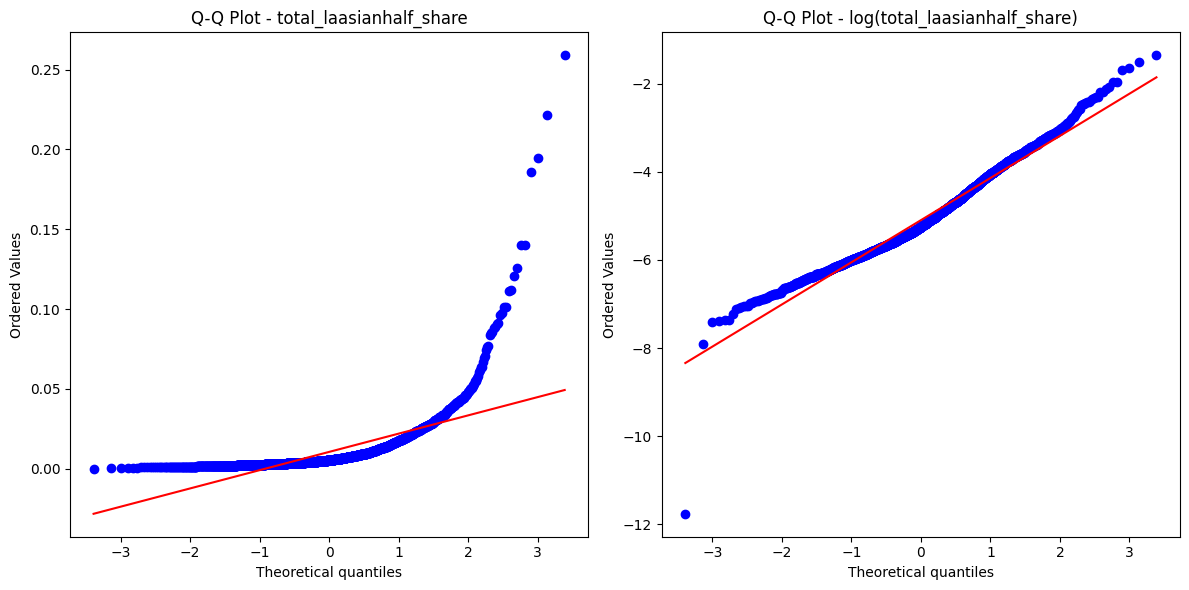

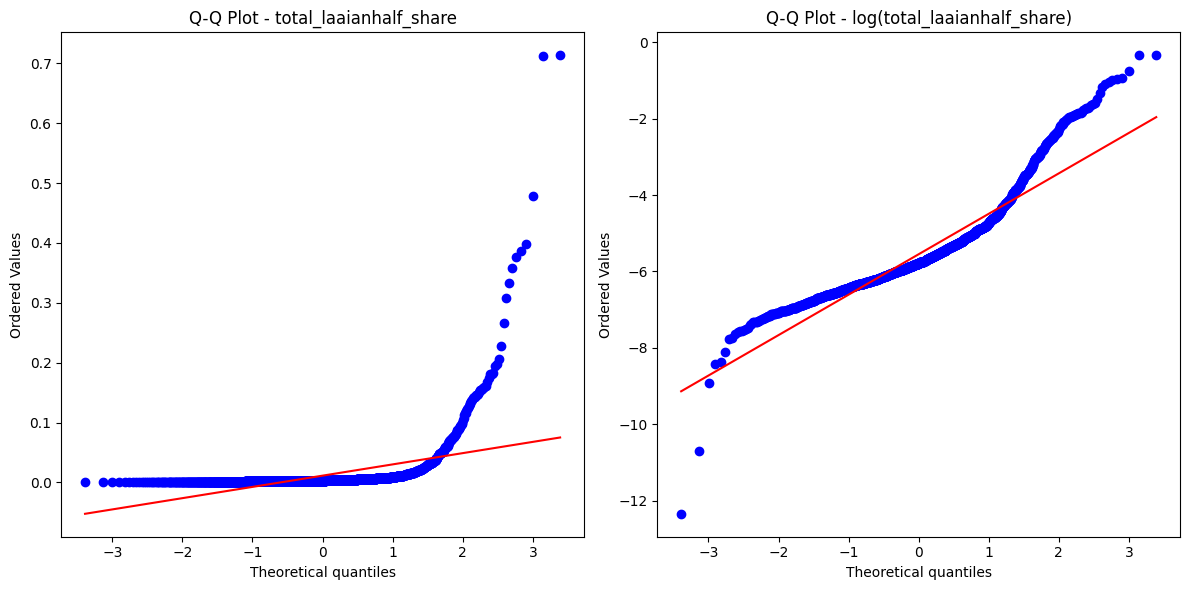

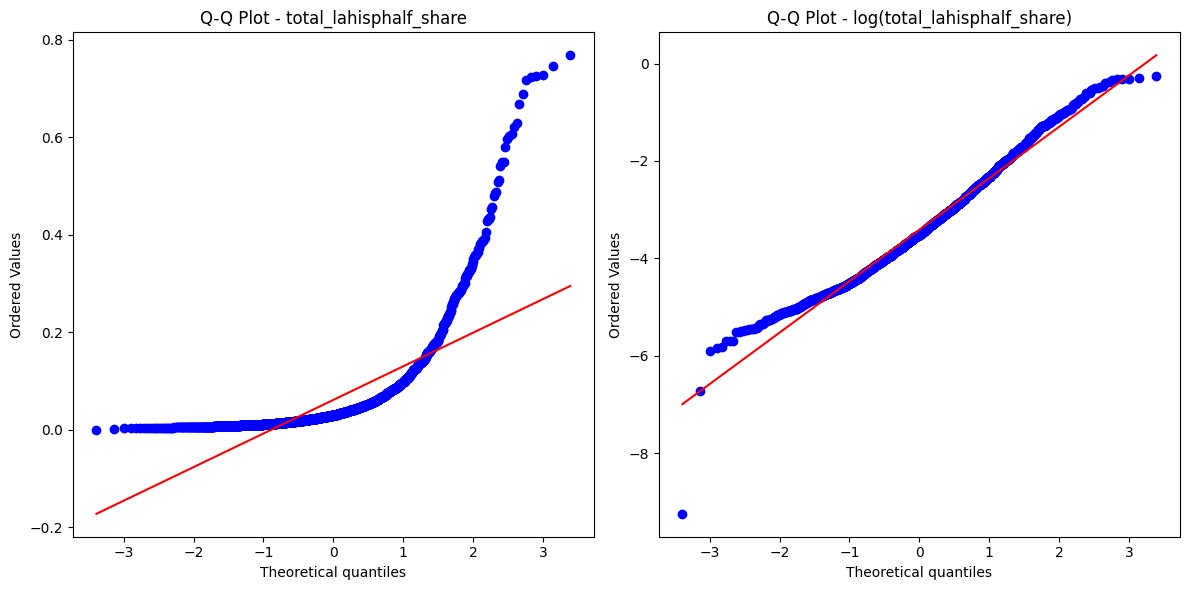

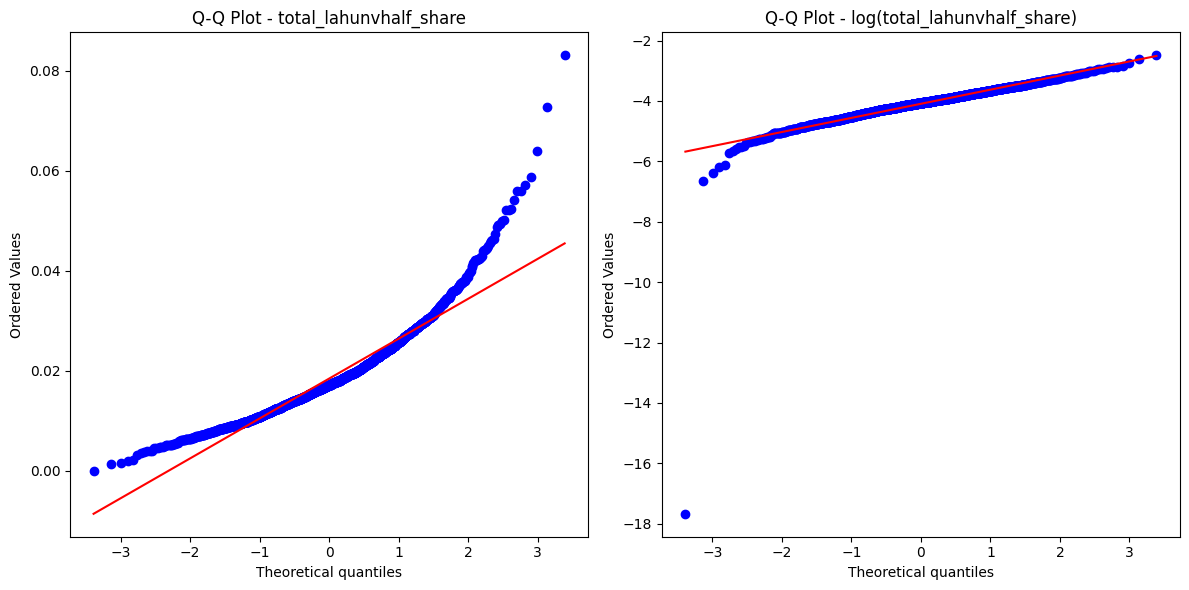

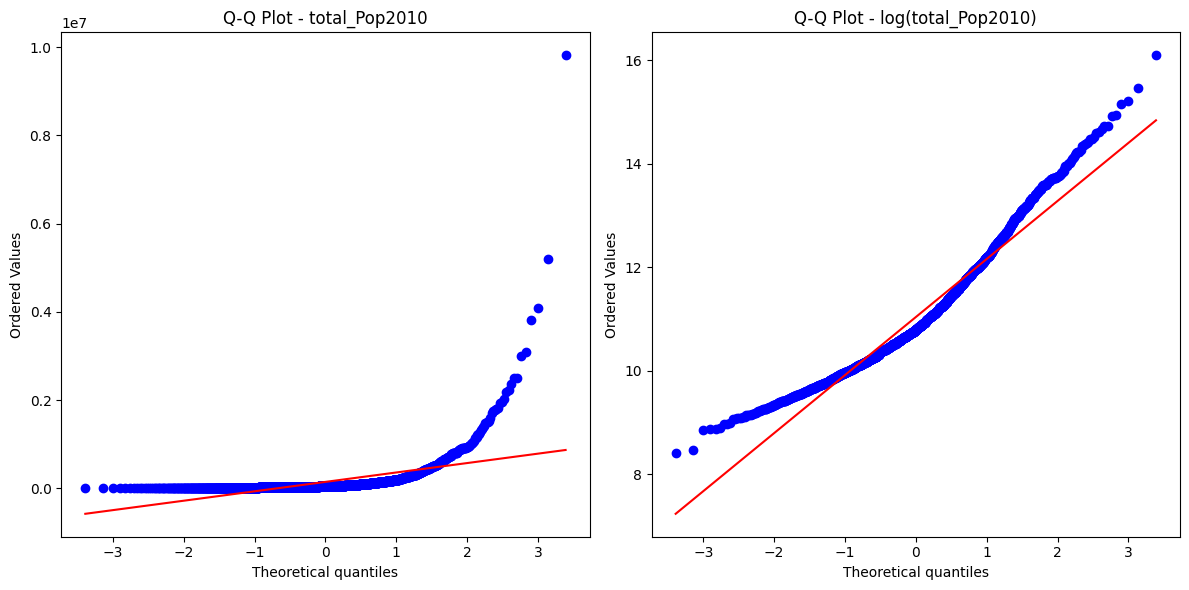

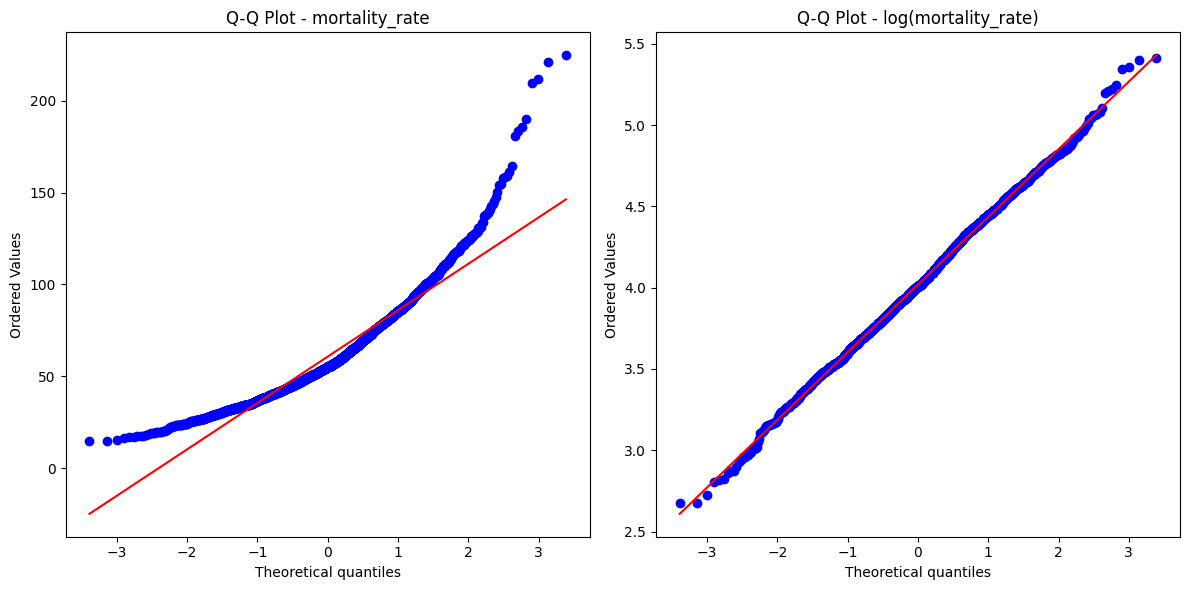

In [182]:
# Generate QQ-plot for each variable before and after a log transfromation
for var in interested_variables:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    stats.probplot(df_reg_var[var], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot - {var}")

    plt.subplot(1, 2, 2)
    stats.probplot(np.log(df_reg_var[var]), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot - log({var})")

    plt.tight_layout()
    plt.show()

The new new log adjust values of our data can be seen below. All variables moving moving forward will be refering to thier log transformed selves.

In [183]:
# Apply a log to all of the interested variables for a more normal distribution
df_reg_trans = np.log(df_reg_var)
df_reg_trans.head()

,avg_median_family_income,total_lapophalf_share,total_lalowihalf_share,total_lawhitehalf_share,total_lablackhalf_share,total_laasianhalf_share,total_laaianhalf_share,total_lahisphalf_share,total_lahunvhalf_share,total_Pop2010,mortality_rate
County_State,,,,,,,,,,,
"Autauga County, AL",11.146741,-0.097563,-1.257507,-0.343675,-1.803636,-4.984795,-5.532072,-3.845880,-3.956330,10.907258,4.161016
"Baldwin County, AL",11.193625,-0.095768,-1.331863,-0.245874,-2.500358,-5.060253,-5.080606,-3.215048,-4.426872,12.113217,4.081840
"Barbour County, AL",10.709795,-0.144512,-0.835999,-0.842027,-0.944762,-5.916353,-5.529458,-3.072206,-3.610337,10.220376,3.690444
"Blount County, AL",11.009368,-0.042590,-1.062628,-0.117505,-4.383440,-6.291803,-5.266497,-2.598907,-4.244880,10.956440,3.446857
"Butler County, AL",10.823186,-0.147994,-0.884602,-0.724489,-1.024845,-4.966289,-5.882674,-4.762371,-3.655841,9.949751,4.741229


### Split Data

To evaluate our model’s performance, we implemented a train-test split, dividing the dataset into an 80% training set and a 20% test set. This approach allows us to assess how well the model generalizes to unseen data while reducing the risk of overfitting. Our goal is to ensure the model produces results that are robust and generalizable, rather than overly tailored to the training data.

In [184]:
# Split Data
X = df_reg_trans.drop(columns=['mortality_rate'])
X = X.copy()

y = df_reg_trans['mortality_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model

We begin by creating a model using all of our features and running an OLS regression on the training set. This serves as a baseline model from which we can refine our final version. The model summary reveals that 6 out of 10 key independent variables are statistically significant at the 5% level, providing insights into which predictors have a meaningful impact on mortality rate.

In [185]:
# Perform OLS regression with statsmodels formula API (use DataFrame for formula)
X_train['mortality_rate'] = y_train

# Fit the initial OLS model with all features
formula = 'mortality_rate ~ ' + ' + '.join(X_train.columns.drop('mortality_rate'))

In [186]:
# Fit the final model with the selected features
final_model = smf.ols(formula, X_train).fit()

# Check the summary of the model
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:         mortality_rate   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     95.83
Date:                Sun, 16 Mar 2025   Prob (F-statistic):          1.05e-154
Time:                        13:22:14   Log-Likelihood:                -476.04
No. Observations:                1584   AIC:                             974.1
Df Residuals:                    1573   BIC:                             1033.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Model Refinement

Next, we implement backward selection to refine our model by minimizing the Bayesian Information Criterion (BIC). This process systematically removes less significant variables, leading to a more parsimonious and optimized model. Based on our selection, the optimal independent variables are:

 * avg_median_family_income
 * total_Pop2010
 * total_laasianhalf_share
 * total_lahunvhalf_share

This refined model improves interpretability while maintaining strong predictive performance.

In [187]:
def criterion(formula, df):
    """
    Calculate the BIC for a given regression model formula and given dataframe.

    Parameters:
    formula (str): The regression model formula.
    df (pandas.DataFrame): The dataframe containing the data.

    Returns:
    float: The BIC value of the fitted model.
    """
    model = smf.ols(formula, df).fit()
    criterion_value = model.bic
    return criterion_value

def remove(df, already_selected_columns, criterion, response='y'):
    """
    Identify the worst column to remove based on the given criterion.
    REMEMBER: The smaller the criterion, the better the model.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    already_selected_columns (set): The set of currently selected columns.
    criterion (function): The criterion function to evaluate the model.
    response (str): The response variable name.

    Returns:
    tuple: The worst column to remove and its criterion value.
    """

    # Initialize the worst criterion and column to None
    worst_criterion = float('inf')
    worst_column = None

    # Iterate over the already selected columns to find the worst column to remove
    for column in already_selected_columns:
        new_columns = already_selected_columns - {column}
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < worst_criterion:
            worst_criterion = current_criterion
            worst_column = column
    return worst_column, worst_criterion

def backward(df, criterion, response='y'):
    """
    Perform backward selection to find the optimal model based on the given criterion.
    REMEMBER: The smallest criterion value is considered the best model fit.
    
    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    criterion (function): The criterion function to evaluate the model.
    response (str): The response variable name.

    Returns:
    set: The set of selected columns in the optimal model.
    """

    # Initialize the set of already selected columns to all columns except the response variable
    already_selected_columns = set(df.columns.drop(response))
    best_criterion = criterion(f'{response} ~ {' + '.join(already_selected_columns)}', df)
    while len(already_selected_columns) > 0:

        # Identify the worst column to remove based on the given criterion
        potential_column, current_criterion = remove(df, already_selected_columns, criterion, response)

        # Check if the model with the worst column removed has a better criterion value
        if current_criterion <= best_criterion:
            already_selected_columns.remove(potential_column)
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
        else:
            break
    final_selection = already_selected_columns
    return final_selection

In [189]:
# Conduct backwards variable selection
backward_vars = backward(X_train, criterion, response='mortality_rate')
backward_vars

Criterion: 1025.9498611911283
Criterion: 1019.1317910285813
Criterion: 1013.7411974354857
Criterion: 1011.6342021043536
Criterion: 1006.0008457120346
Criterion: 1005.5930035342363


{'avg_median_family_income',
 'total_Pop2010',
 'total_laasianhalf_share',
 'total_lahunvhalf_share'}

### Final Model

We then fit an OLS regression model using the optimal independent variables identified through backward selection. The model summary provides insights into its performance, helping us assess improvements in predictive power and interpretability compared to the initial model.

In [190]:
# Fit the final model with the selected features
final_formula = 'mortality_rate ~ ' + ' + '.join(backward_vars)
final_model = smf.ols(final_formula, X_train).fit()

# Check the summary of the model
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:         mortality_rate   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     233.8
Date:                Sun, 16 Mar 2025   Prob (F-statistic):          9.10e-158
Time:                        13:22:35   Log-Likelihood:                -484.38
No. Observations:                1584   AIC:                             978.8
Df Residuals:                    1579   BIC:                             1006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### Interpretation of the coefficients

This refined final model highlights four key factors influencing mortality rate in a log-log regression framework:

* Income (avg_median_family_income) – A 1% increase in average tract median family income is associated with a 0.43% decrease in a county's mortality rate, indicating a strong negative relationship.
* Population size (total_Pop2010) – A 1% increase in population size corresponds to a 0.10% decrease in a county's mortality rate, suggesting possible benefits from urban infrastructure or healthcare access.
* Low vehicle access (total_lahunvhalf_share) – A 1% increase in the share of individuals with limited supermarket access leads to a 0.07% increase in a county's mortality rate, highlighting the importance of food accessibility in public health.
* Asian low access share (total_laasianhalf_share) – A 1% increase in the share of Asian individuals in low-access areas is associated with a 0.06% decrease in mortality rate. This suggests that other factors, such as socioeconomic status or community resources, may mitigate the negative effects of low food access for this demographic.

Since the model uses log-transformed variables, the coefficients can be interpreted as elasticities—showing percentage changes in mortality rate in response to percentage changes in the predictors.

### Evaluate Model

The final model's training and test RMSE values are very similar, indicating that the model generalizes well to unseen data and is not overfitting. This suggests that the model captures meaningful patterns without being overly complex or tailored to the training data.

In [191]:
# Make predictions on both training and test sets
train_predictions = final_model.predict(X_train)
test_predictions = final_model.predict(X_test)

# Calculate RMSE for both training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Training RMSE: 0.3285241830474116
Test RMSE: 0.33647111176037964


A residual plot of the final model's standardized residuals shows no systematic patterns. This suggests that the model captures the main linear relationships well and does not exhibit clear signs of nonlinearity. This reduces concerns about omitted variable bias.

In [194]:
# Create standardize function and apply to residuals
def standardize(X):
    return (X - X.mean()) / X.std()
standard_resid=standardize(final_model.resid)

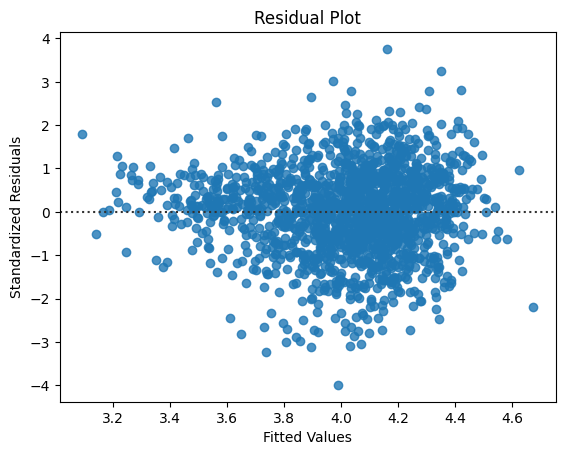

In [195]:
# Create Residual Plot
sns.residplot(x=final_model.fittedvalues, y=standard_resid)

plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")
plt.title("Residual Plot")
plt.show()

Based on the Variance Inflation Factor (VIF) calculations, the level of multicollinearity in the model is within acceptable limits for our analysis. None of the independent variables have a VIF value exceeding 5, indicating that multicollinearity is not a significant concern.

In [196]:
# Calculate VIF factors
exog = final_model.model.exog
names = final_model.params.index
for i in range(1, exog.shape[1]):
    print(f'VIF: {names[i]}: {variance_inflation_factor(exog, i): .3f}')

VIF: total_Pop2010:  2.108
VIF: total_lahunvhalf_share:  1.504
VIF: avg_median_family_income:  2.176
VIF: total_laasianhalf_share:  2.451


### Model Assumptions

Now that we have an optimal model, it is essential that we check the 4 model assumptions. The 4 assumptions that we will test are as follows:

1. Normality assumption: The residuals should be normally distributed.
2. Linearity assumption: The relationship between the independent variables and the response is linear.
3. Identical assumption: The residuals have constant variance. 
4. Independence assumption: The residuals are independent from each other.

If any of these assumptions are violated, this could potentially mean that our model is biased/inaccurate, coefficients to be uninterpretable, and overall leading to poor performance. We performed the following visual verifications to ensure that all of the assumptions are satisfied.

#### Normality Assumption

For the normality assumption, we can display a Q-Q plot and analyze how well it fits the reference line. We perform the test here using the standardized residuals. 

As shown in the Q-Q plot, the residuals follow the 45 degree reference line very closely. Because the plot essentially compares the theoretical values (expected values) and the observed samples values, the plot clearly shows that the normality assumption is satisfied. 

So, the **normality assumption is satisfied**. 

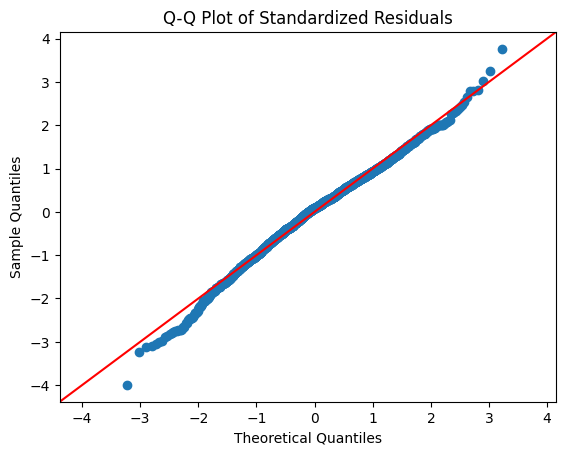

In [197]:
# Generate Q-Q plot
sm.qqplot(standard_resid, line='45', fit=True)
plt.title('Q-Q Plot of Standardized Residuals')
plt.show()

#### Linearity and Identical Assumptions

For both the linearity assumption and the identical assumption, we can use the plot of predicted values vs. the standardized residuals. As shown, the data points are randomly scattered about the x-axis, with no distinctive pattern or slope. 

This proves that the **linearity and identical assumptions are satisfied**.

Text(0.5, 1.0, 'Fitted values vs Standardized residuals')

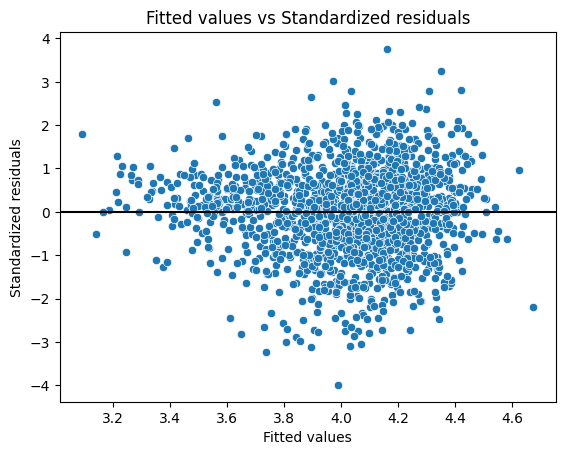

In [198]:
fig, ax = plt.subplots()
sns.scatterplot(x=final_model.fittedvalues, y=standard_resid, ax=ax).axhline(0, color="black")
ax.set_xlabel("Fitted values")
ax.set_ylabel("Standardized residuals")
plt.title("Fitted values vs Standardized residuals")

#### Independence Assumption

Finally, we move to the independence assumption which can be proved using the autocorrelation function. As shown in the autocorrelation function graph of the standardized residuals, there does not seem to be a noticeable pattern of the function from one lag to the next.

So, we can claim that the **independence assumption is satisfied**.

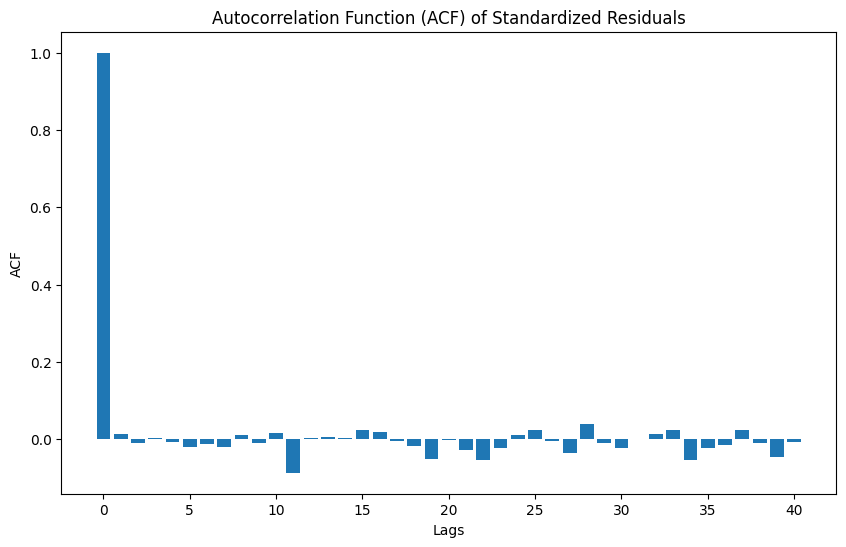

In [199]:
# Compute the ACF of the residuals
acf_values = acf(standard_resid, nlags=40)

# Plot the ACF of the residuals
plt.figure(figsize=(10, 6))
plt.bar(range(len(acf_values)), acf_values)
plt.title('Autocorrelation Function (ACF) of Standardized Residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

## Potential Limitations and Shortcomings of Analysis

One limitation from our hypothesis test is because the mortality rate data did not pass the assumption of normality, we could not use parametric tests to model mortality rate using a known distribution such as the normal distribution. This limited the analysis we could've performed for the mortality rates of low access versus high access counties such as predicting confidence levels for the mortality rate in each category of the county. With our Kolmogorov-Smirnov test, the result only limited our analysis on determining if the distribution of mortality rate of low access versus high access are part of the same distribution. Because of this, nothing more can be said about the distributions in terms of how different the distributions are because we are not aware of the underlying distribution the mortality rate follows. 

One of the main limitations of our analysis was the availability of the data that we were looking for. While many of the features in our food access dataset were interesting, many of them were very similiar and in some cases, highly correlated with each other, limiting our use of them to avoid multicollinearity. Even so, with our optimal regression model, there may be some correlation between variables, which may have distorted some relationships. 

There are certainly other variables that affect mortality rate that we were interested in analyzing, like a binary variable on whether the county was rural or not, educational level, food affordability, and much more. These features could have given us a better picture of the current landscape of food accessibility within the US, and further insight into how we can address the prevalence of metabolic and nutritional diseases.

As with many datasets, the limited timeframe of the data may limit some of the external validity that our results can show. The data from our datasets were collected relatively recently, with the food access data from 2019 and the mortality data from the range of 2018-2023. However, more recent data can always help the validity of our results. Particularly with public health studies, data from before and after the COVID-19 pandemic can be drastically different so having up-to-date data would help with providing accurate and relevant results.


## Conclusion

From our hypothesis test, we ran a Kolmogorov-Smirnov test on the mortality rates of low access counties vs high access counties. The data failed the assumptions for parametric tests, which prompted our use of non-parametric tests such as the Kolmogorov-Smirnov test and the permutation test. The test resulted in a p-value of 7.224501751217153e-18 < 0.05, rejeceting the null hypothesis in support for the alternative: the distribution of mortality rate of low access counties is different from the distribution of mortality rate of high access counties. The empirical CDFs for both the mortality rates in low access versus high access counties showed different distributions, which aligned with the result of our KS test. We also ran a permutation test to measure the difference in means of the mortality rate between low access and high access counties using random shuffling to sample mortality rates. With a p-value of 0, we reject the null hypothesis that the difference between the means is 0 in favor for the alternative. Both of the non-parametric hypothesis tests indicated that mortality rate is different in low access counties from high access counties.

From our regression model, we can observe that there are a few paramount variables that explain the mortality rate due to metabolic and nutritional diseases in a given county. From our model we can see that the feature with the largest effect size (or coefficient) is 'avg_median_family_income'. As one might be able to expect, as the median income of a county goes up, it has a negative affect on the response variable 'mortality_rate', bringing it down. 

As mentioned in our introduction, nutritional and metabolic diseases are one of the most prevalent, yet preventable diseases that affect the communities around us. These diseases are often contributed through factors like diet and socioeconomic conditions. As shown from our regression model, counties with higher income tend to lower its respective mortality rates to these preventable diseases. Counties with higher median income are typically associated with better-funded infrastructure that can support the wellbeing and livelihood of its residents, like access to supermarkets with fresh, healthy food. 

Another significant feature was 'total_lahunvhalf_share', which had a positive effect on 'mortality_rate'. This feature explained the total share of individuals in the county that did not have a vehicle and were more than a half-mile away from a supermarket. Consequently, these residents may result to relying on closer, more accessible food sources like convenience stores and fast food outlets to satisfy their diet.

What does this mean from a public health perspective? It implies that there needs to be an increase of funding into the infrastructure of lower-income communities with limited access to fresh, healthy food. From building a comprehensive public transportation system to increasing educational awareness on the benefits of healthy food, there are many policy changes that can be made to address the high mortality rate due to these nutritional and metabolic diseases. With enough advocacy, we can hope to see a future where healthy food is easily accessible to all and a declining mortality rate due to these preventable diseases.